# Data description


Online learning activities are on the rise. Further helped by the recent pandemic of covid-19, educational institutions have had periods of full online activity. And currently, there is a lack of means with which educators can determine if their students are engaging in online class activities, and also determine whether engagement is one of the augmenting-factors of academic success at all. With universities moving their class materials online, there is also an increased opportunity to collect data on student-populations for studying the success factors of a particular student within a semester.
This data aims to model the engagement-level of students in universities. It supplements the manuscript <citing the paper>. While the data points to the activities of university students only, it would serve as a guideline to replicate similar modelling methods designed for other kinds of educational institutions as well.

The raw data for this modelling task had been acquired from a private database of public university data that isn't accessible openly. The database contained 435 tables. The tables pointed to both actionable and non-actionable information. Of the actionable information, there were data related to user information, course information, course enrolments, assignment information, questionnaires, quizes, etc. The non-actionable information were related to website and webpage configuration.

In <paper>, the proposed model for engagement-level takes several inputs. Not all the tables contain the input data needed for the model. Specifically, only 20 of the 435 tables contained the required data that serve as the inputs. Furthermore, the tables contained data in a disjoint manner. For example, one table would have course names and a course id, another table would have user names and the course id's that they are involved in, and again, another would have the faculty that is offering the course. Therefore, the tables would have to be transformed and merged in various ways to ultimately provide meaning for the proposed engagement model.

**Variable naming:** 
1. The names of the dataframes are identical to the names of the postgres tables.
2. A modified dataframe (derived from the psql tables) have a 'vx' suffix where v stands for version and x is the version number. The first modified version is named 'df_v2'.
3. the naming of other variables is such that the last part (after '_') indicates the Postgres table it's used in/taken data from.

In [216]:
import sys, os

Check the version of python you're running

In [217]:
sys.executable

'C:\\Users\\kople\\anaconda3\\python.exe'

In [218]:
sys.path

['C:\\Program Files\\JetBrains\\DataSpell 2022.1\\plugins\\python-ce\\helpers-pro\\jupyter_debug',
 'C:\\Program Files\\JetBrains\\DataSpell 2022.1\\plugins\\python-ce\\helpers\\pydev',
 'C:\\Users\\kople\\Documents\\Work\\RA\\Student-Engagement_Prediction\\notebooks\\data_consolidation',
 'C:\\Users\\kople\\Documents\\Work\\RA\\Student-Engagement_Prediction',
 'C:\\Users\\kople\\Documents\\Personal Git repos\\Water-Quality-Prediction',
 'C:\\Users\\kople\\anaconda3\\python39.zip',
 'C:\\Users\\kople\\anaconda3\\DLLs',
 'C:\\Users\\kople\\anaconda3\\lib',
 'C:\\Users\\kople\\anaconda3',
 '',
 'C:\\Users\\kople\\AppData\\Roaming\\Python\\Python39\\site-packages',
 'C:\\Users\\kople\\anaconda3\\lib\\site-packages',
 'C:\\Users\\kople\\anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\kople\\anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\kople\\anaconda3\\lib\\site-packages\\Pythonwin']

Check the working directory

In [219]:
os.getcwd()

'C:\\Users\\kople\\Documents\\Work\\RA\\Student-Engagement_Prediction\\notebooks\\data_consolidation'

# Imports

In [220]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from tqdm.notebook import tqdm_notebook,trange
from time import sleep


# Configuring Plotly

Setting the renderer (https://plotly.com/python/renderers/)

In [221]:
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [222]:
#pio.renderers.default = "notebook"

Available themes

In [223]:
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [224]:
template = 'plotly_dark'

# Data path strings

Set path to data extracted from database

In [225]:
path = 'C:/Users/kople/Documents/Work/RA/data/raw/sess1819sem2/'

Path to save processed/consolidated dataframes later

In [226]:
ppath = 'C:/Users/kople/Documents/Work/RA/data/processed/sess1819sem2/'

In [227]:
assignment_grades = pd.read_csv(f'{path}assignment_grades.csv')
assignment_submission = pd.read_csv(f'{path}assignment_submission.csv')
assignment_user_mapping = pd.read_csv(f'{path}assignment_user_mapping.csv')

# Custom functions

## items_per_user

In [228]:
def items_per_user(df,feature, parent_feature=None):
    """For a given dataframe and feature within that dataframe, items_per_user() returns
    a dataframe with the number of items in the feature that belong to or are attributed 
    to the user id. Note that the function assumes that the df has a column 'userid'."""

    #preprocessing: sort the df by userid
    users = df.sort_values(by='userid').userid.unique()
    n_items_per_user = []
    if feature not in df.columns:
        print('The column', feature,' does not exist')
        pass
    if parent_feature==None:

        for user in users:
                #select portion of dataframe specific to the single user and then count number of unique values for the feature
                n_items=df[df.userid==user][feature].nunique()
                #add the data to the array
                n_items_per_user.append(n_items)
                #create the dataframe
        feature = 'number_of_' + feature +'s' #changing the name of the item column
        items_per_user_df = pd.DataFrame({'userid':users,feature:n_items_per_user})

    # else:
    #     # insert each item of the parent feature into a list
    #     parents = df[parent_feature].sort_values().unique()
    #     users = df.sort_values(by=parent_feature).userid.unique()
    #
    #     for user in users: # selecting a user
    #         for parent in parents: # iterating through all the parent_feature items
    #             n_items = df[(df.userid==user)&(df[parent_feature]==parent)][feature].nunique()
    #             n_items_per_user.append(n_items)
    #     # create the dataframe
    #     feature = 'number_of_' + feature +'s' #changing the name of the item column
    #     parent_feature = parent_feature+'id'
    #     items_per_user_df = pd.DataFrame({'userid':users, parent_feature:parent, feature:n_items_per_user})



        #
        # for item in items_parent_feature:
        #     # select portion of dataframe specific to the item, count the number of items in the child feature and put into list
        #     n_items = df[df[parent_feature]==item][feature].nunique()
        #     users = df[df[parent_feature]==item].userid.unique()
        #     n_items_per_user.append(n_items)

    return items_per_user_df

In [229]:
help(items_per_user)

Help on function items_per_user in module __main__:

items_per_user(df, feature, parent_feature=None)
    For a given dataframe and feature within that dataframe, items_per_user() returns
    a dataframe with the number of items in the feature that belong to or are attributed 
    to the user id. Note that the function assumes that the df has a column 'userid'.



## pcnt_df

In [230]:
def pcnt_df_old(df,feature,x,method ='>'):
    """Calculate the portion(in percentage) of the dataframe that is populated by values greater or lesser than x"""
    #preprocessing
    df_notna = df[df[feature].notna()] #select portion of dataframe that is not empty

    if feature not in df.columns:
        raise Exception(feature, "is not a column of the dataframe")
    #if x not in df[feature]:
        #raise Exception(x, "is not within the range of the selected feature.")
    else:
        if method=='>':
            df_above_x = df_notna[df_notna[feature]>x]
            pcnt = df_above_x.shape[0]/df_notna.shape[0]

        if method=='<':
            df_below_x = df_notna[df_notna[feature]<x]
            pcnt = df_below_x.shape[0]/df_notna.shape[0]

        if method=='>=':
            df_above_equal_x = df_notna[df_notna[feature]>=x]
            pcnt = df_above_equal_x.shape[0]/df_notna.shape[0]
            
        if method=='<=':
            df_below_equal_x = df_notna[df_notna[feature]<=x]
            pcnt = df_below_equal_x.shape[0]/df_notna.shape[0]

        return pcnt*100

    

In [231]:
def pcnt_df(df,feature,lbound=None,hbound=None):
    """Calculate the portion(in percentage) of the dataframe that is populated by values bound by lbound and hbound (You can also use only one bound)"""
    #preprocessing
    df_notna = df[df[feature].notna()] #select portion of dataframe that is not empty

    if feature not in df.columns:
        raise Exception(feature, "is not a column of the dataframe")
    #if x not in df[feature]:
    #raise Exception(x, "is not within the range of the selected feature.")
    else:
        if hbound is None:
            df_above_lbound = df_notna[df_notna[feature]>lbound]
            pcnt = df_above_lbound.shape[0]/df_notna.shape[0]

        elif lbound is None:
            df_below_hbound = df_notna[df_notna[feature]<hbound]
            pcnt = df_below_hbound.shape[0]/df_notna.shape[0]

        elif lbound is not None and hbound is not None:
            df_btn_l_h = df_notna[(df_notna[feature]>lbound)&(df_notna[feature]<hbound)]
            pcnt = df_btn_l_h.shape[0]/df_notna.shape[0]

        return pcnt*100

## get_df_name(df)

In [232]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

## find_stats

In [233]:
# find statistical max,min and mean for the data on attempts
def find_stats(df,attempt_column):
    stat_all = []
    for user in df.userid.unique():
        df_user = df.loc[df.userid==user]
        max_attempt = df_user[attempt_column].max()
        min_attempt = df_user[attempt_column].min()
        mean_attempt = df_user[attempt_column].mean()
        stat_user = [max_attempt,min_attempt,mean_attempt]
        stat_all.append(stat_user)

    max_attempts = [el[0] for el in stat_all]
    min_attempts = [el[1] for el in stat_all]
    mean_attempts = [el[2] for el in stat_all]

    df2 = pd.DataFrame()
    df2['userid'] = df.userid.unique()
    df2[f'max_{attempt_column}'] = max_attempts
    df2[f'min_{attempt_column}'] = min_attempts
    df2[f'mean_{attempt_column}'] = mean_attempts

    return df2

# Assignment metadata

In [234]:
assign_meta = pd.read_csv(f'{path}assignment_meta.csv')

In [235]:
assign_meta

id  course                                               name  \
0          1       4                               Write an inline text   
1          2       4  Dropbox Paper Submission - Meaning making in p...   
2          3       4                     Building defect knowledge game   
3          4       4                             Defect portfolio video   
4          5       4              Defect Presentation 11th October 2017   
...      ...     ...                                                ...   
11026  13182    1613                                         Assignment   
11027  13183    1613                                            Imtihan   
11028  13184    1613                               Imtihan Fiqih Ibadat   
11029  10916    3799  Group Assignment - Final Report Submission (Gr...   
11030  11613    3805                 Submission Individual assignment 1   

                                                   intro  introformat  \
0      <p>How do we change the look of the platform a...            1   
1      <p>Dropbox Paper Submission - Meaning making i...            1   
2      <p><span>You are to create a game to help with...            1   
3      <p><span>You are to submit a defects portfolio...            1   
4      <p>Hi all,</p>\n<p>Could you please submit mat...            1   
...                                                  ...          ...   
11026                                                NaN            1   
11027  <p>Assalamualaikum</p>\r\n<p>Semoga dimudahkan...            1   
11028                                                NaN            1   
11029  <p dir="ltr"><span>Group Assignment (for all, ...            1   
11030          <p>Please submit your tutorial 1 here</p>            1   

       alwaysshowdescription  nosubmissions  submissiondrafts  \
0                          1              0                 0   
1                          1              0                 0   
2                          1              0                 0   
3                          1              0                 0   
4                          1              0                 0   
...                      ...            ...               ...   
11026                      1              0                 0   
11027                      1              0                 0   
11028                      1              0                 0   
11029                      1              0                 0   
11030                      1              0                 0   

       sendnotifications  sendlatenotifications  ...  \
0                      0                      0  ...   
1                      0                      0  ...   
2                      0                      1  ...   
3                      0                      0  ...   
4                      0                      0  ...   
...                  ...                    ...  ...   
11026                  0                      0  ...   
11027                  0                      0  ...   
11028                  0                      0  ...   
11029                  0                      0  ...   
11030                  0                      0  ...   

       requireallteammemberssubmit  teamsubmissiongroupingid  blindmarking  \
0                                0                         0             0   
1                                0                         0             0   
2                                0                         4             0   
3                                0                         0             0   
4                                0                         0             0   
...                            ...                       ...           ...   
11026                            0                         0             0   
11027                            0                         0             0   
11028                            0                         0             0  

In [236]:
assign_meta.describe()

id        course   introformat  alwaysshowdescription  \
count  11031.000000  11031.000000  11031.000000           11031.000000   
mean    7005.099356   2682.099084      0.997280               0.893391   
std     3723.621051   1500.728648      0.053794               0.308629   
min        1.000000      4.000000      0.000000               0.000000   
25%     3963.500000   1558.000000      1.000000               1.000000   
50%     7170.000000   2541.000000      1.000000               1.000000   
75%    10228.500000   3993.000000      1.000000               1.000000   
max    13184.000000   5191.000000      2.000000               1.000000   

       nosubmissions  submissiondrafts  sendnotifications  \
count   11031.000000      11031.000000       11031.000000   
mean        0.031004          0.076602           0.037531   
std         0.173335          0.265971           0.190067   
min         0.000000          0.000000           0.000000   
25%         0.000000          0.000000           0.000000   
50%         0.000000          0.000000           0.000000   
75%         0.000000          0.000000           0.000000   
max         1.000000          1.000000           1.000000   

       sendlatenotifications       duedate  allowsubmissionsfromdate  ...  \
count           11031.000000  1.103100e+04              1.103100e+04  ...   
mean                0.028737  1.358069e+09              1.396341e+09  ...   
std                 0.167075  5.180012e+08              4.677814e+08  ...   
min                 0.000000  0.000000e+00              0.000000e+00  ...   
25%                 0.000000  1.540915e+09              1.539792e+09  ...   
50%                 0.000000  1.553270e+09              1.551974e+09  ...   
75%                 0.000000  1.558454e+09              1.556834e+09  ...   
max                 1.000000  1.733448e+09              1.732667e+09  ...   

       teamsubmission  requireallteammemberssubmit  teamsubmissiongroupingid  \
count    11031.000000                 11031.000000              11031.000000   
mean         0.050494                     0.003717                 19.420814   
std          0.218972                     0.060855                134.824350   
min          0.000000                     0.000000                  0.000000   
25%          0.000000                     0.000000                  0.000000   
50%          0.000000                     0.000000                  0.000000   
75%          0.000000                     0.000000                  0.000000   
max          1.000000                     1.000000               1227.000000   

       blindmarking  revealidentities   maxattempts  markingworkflow  \
count  11031.000000           11031.0  11031.000000     11031.000000   
mean       0.000907               0.0     -0.968906         0.001904   
std        0.030096               0.0      0.342559         0.043592   
min        0.000000               0.0     -1.000000         0.000000   
25%        0.000000               0.0     -1.000000         0.000000   
50%        0.000000               0.0     -1.000000         0.000000   
75%        0.000000               0.0     -1.000000         0.000000   
max        1.000000               0.0     10.000000         1.000000   

       markingallocation  sendstudentnotifications  \
count       11031.000000              11031.000000   
mean            0.001360                  0.994198   
std             0.036852                  0.075952   
min             0.000000                  0.000000   
25%             0.000000                  1.000000   
50%             0.000000                  1.000000   
75%             0.000000                  1.000000   
max             1.000000                  1.000000   

       preventsubmissionnotingroup  
count                 11031.000000  
mean                      0.020306  
std                       0.141053  
min                       0.000000  
25%                       0.000000  
50%                       0

<AxesSubplot:>

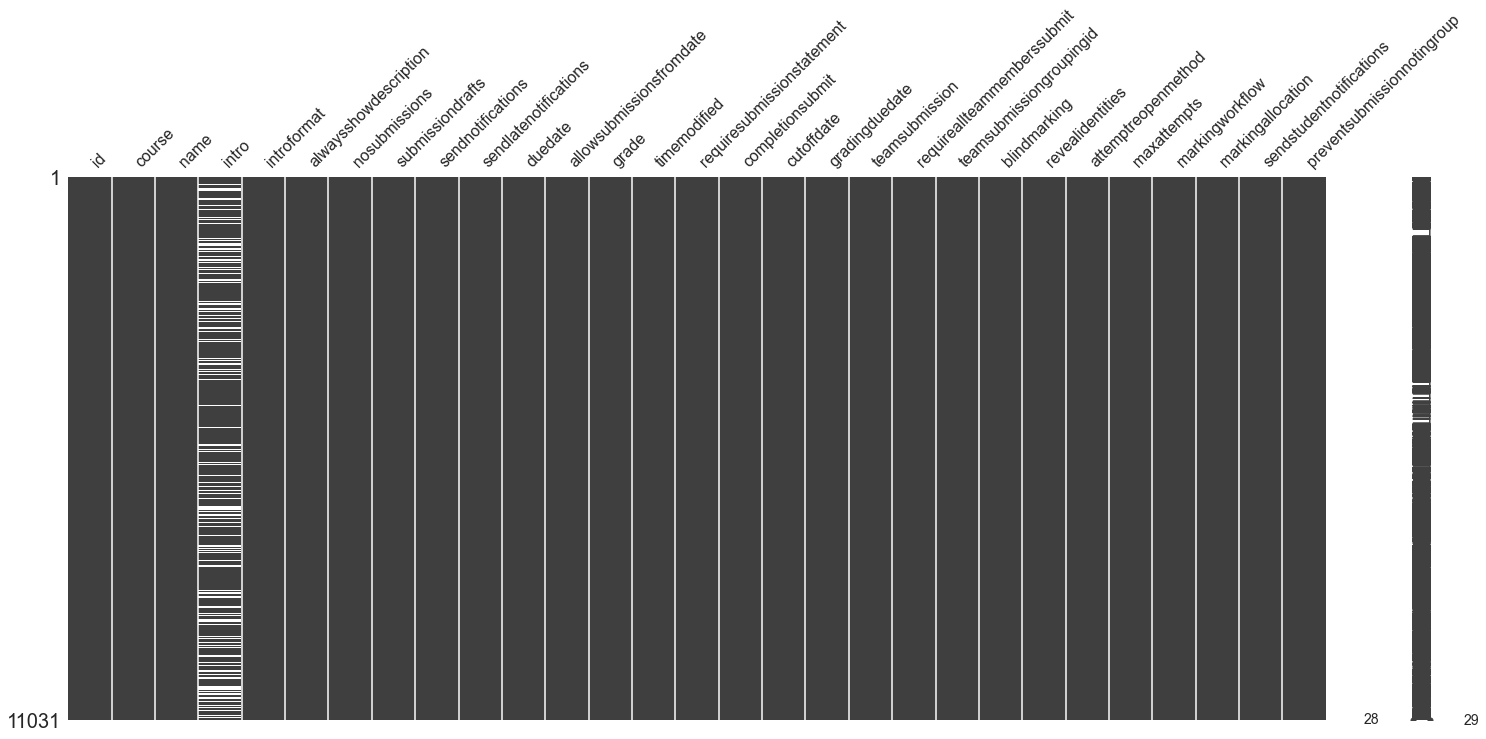

In [237]:
msno.matrix(assign_meta)

Selecting the relevant columns

In [238]:
assign_meta = assign_meta[['id','course','name','grade']]

In [239]:
assign_meta

id  course                                               name  grade
0          1       4                               Write an inline text    100
1          2       4  Dropbox Paper Submission - Meaning making in p...    100
2          3       4                     Building defect knowledge game    100
3          4       4                             Defect portfolio video    100
4          5       4              Defect Presentation 11th October 2017    100
...      ...     ...                                                ...    ...
11026  13182    1613                                         Assignment    100
11027  13183    1613                                            Imtihan    100
11028  13184    1613                               Imtihan Fiqih Ibadat    100
11029  10916    3799  Group Assignment - Final Report Submission (Gr...    100
11030  11613    3805                 Submission Individual assignment 1     10

[11031 rows x 4 columns]

In [240]:
assign_meta.grade.describe()

count    11031.000000
mean        91.664582
std         26.354981
min         -8.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: grade, dtype: float64

In [241]:
assign_meta.grade.unique()

array([100,   0,   5,  15,  10,  20,  65,  25,  -2,  -3,   3,  80,  60,
        75,  40,   7,  12,  50,  30,   8,   4,  -1,  35,   1,  -6,  -5,
        -7,  -8,   2,   9,  70,  16], dtype=int64)

# Assignment grades

In [242]:
assignment_grades

id  assignment  userid  timecreated  timemodified  grader  grade  \
0            1         378    3213   1536750002    1536749769       2   -1.0   
1            2         378    3006   1536750003    1536749811       2   -1.0   
2            3         378    3119   1536750003    1536749816       2   -1.0   
3            4         378    3118   1536750004    1536749821       2   -1.0   
4            5         378    3005   1536750004    1536749950       2   -1.0   
...        ...         ...     ...          ...           ...     ...    ...   
166096  180948        7155   20184   1605666483    1605666802     926   17.0   
166097  180947        7151   20184   1605666162    1605667397     926   30.0   
166098  180949        7579   11065   1605667904    1605668029     926   10.0   
166099  180950        7579   19157   1605668115    1560900678     926   -1.0   
166100  180951       12919   12071   1616025641    1616025641     544   -1.0   

        attemptnumber  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
166096              0  
166097              0  
166098              0  
166099              0  
166100              0  

[166101 rows x 8 columns]

<AxesSubplot:>

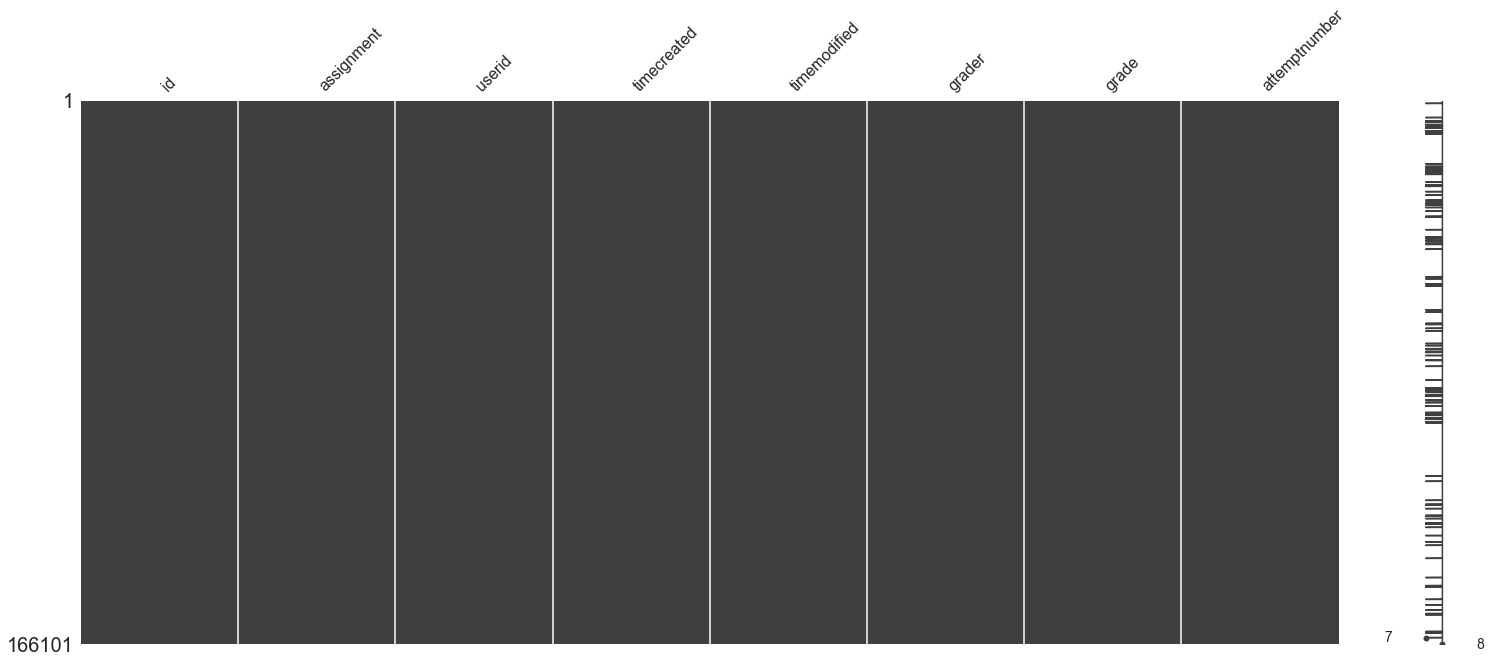

In [243]:
msno.matrix(assignment_grades)

In [244]:
assignment_grades.describe()

id     assignment         userid   timecreated  \
count  166101.000000  166101.000000  166101.000000  1.661010e+05   
mean    95661.414573    7225.889826   11223.647889  1.552435e+09   
std     50738.999432    3773.008914    6023.295174  6.652291e+06   
min         1.000000      25.000000      32.000000  1.536750e+09   
25%     55201.000000    3822.000000    6229.000000  1.545860e+09   
50%     97345.000000    7909.000000   10522.000000  1.554473e+09   
75%    139115.000000   10429.000000   15636.000000  1.557907e+09   
max    180951.000000   13176.000000   28166.000000  1.616026e+09   

       timemodified         grader          grade  attemptnumber  
count  1.661010e+05  166101.000000  165855.000000  166101.000000  
mean   1.552648e+09     474.356133       2.269411       0.000247  
std    6.644536e+06    3064.895220      15.100271       0.016088  
min    1.536750e+09       2.000000      -1.000000       0.000000  
25%    1.546065e+09       2.000000      -1.000000       0.000000  
50%    1.554630e+09       2.000000      -1.000000       0.000000  
75%    1.558083e+09       2.000000      -1.000000       0.000000  
max    1.616026e+09   27964.000000     100.000000       2.000000

In [245]:
#shape of dataframe
print(assignment_grades.shape)

#number of unique id's
print(assignment_grades.id.nunique())

#number of unique userid's
print(assignment_grades.userid.nunique())

#Checking number of unique assignments
print(assignment_grades.assignment.nunique())

#number of unique graders
print(assignment_grades.grader.nunique())

print('')
print('Attempt types')
#types of attempts
print(assignment_grades.attemptnumber.value_counts())

(166101, 8)
166101
17266
6851
363

Attempt types
0    166061
1        39
2         1
Name: attemptnumber, dtype: int64


## Number of assignments per user

In [246]:
assignment_per_user_assignmentgrades = items_per_user(assignment_grades, 'assignment')

In [247]:
assignment_per_user_assignmentgrades

userid  number_of_assignments
0          32                      2
1          58                      2
2          64                     17
3          65                     13
4          66                     26
...       ...                    ...
17261   28156                      1
17262   28159                      1
17263   28161                      1
17264   28165                      1
17265   28166                      1

[17266 rows x 2 columns]

In [248]:
fig = px.scatter(assignment_per_user_assignmentgrades,
                 x="userid",
                 y="number_of_assignments",
                 color="number_of_assignments",
                 template=template)
fig.show()

In [249]:
assignment_per_user_assignmentgrades.describe()

userid  number_of_assignments
count  17266.000000           17266.000000
mean   12087.402989               9.618035
std     6635.138300              10.694494
min       32.000000               1.000000
25%     6599.250000               3.000000
50%    11663.500000               6.000000
75%    16802.750000              12.000000
max    28166.000000              90.000000

Shah: So on average, each student has 9 assignments. The most assignments a student has is 90?! Can we do a histogram or box plot on this?

Zayan: Maybe the 90 assignment userid is not a student. Maybe someone from Citra or something? I think it's simply impossible for a student to have 90 assignments. Can we treat it as an outlier?

In [250]:
fig = px.histogram(assignment_per_user_assignmentgrades, x='number_of_assignments')
fig.show()

In [251]:
fig = px.box(assignment_per_user_assignmentgrades, y='number_of_assignments')
fig.show()

In [252]:
#assignment_per_user_assignmentgrades.to_csv(f'{ppath}assignment_per_user.csv')

# Assignment submission

In [253]:
assignment_submission

id  assignment  userid  timecreated  timemodified     status  \
0            1          29      30   1536036211    1536036211        new   
1            2          36    1050   1536116105    1536116105        new   
2        96223        6850   11257   1550732015    1550732015        new   
3           10          15      47   1536286329    1536286329        new   
4        99745        7300    6477   1551165200    1551191779  submitted   
...        ...         ...     ...          ...           ...        ...   
257888  282536        7316    6614   1620177302    1620177302        new   
257889  282537       10454    6614   1620177379    1620177379        new   
257890  282538        8906    4041   1620705086    1620705086        new   
257891  282539        3454   10360   1621339410    1621339410        new   
257892  282540        4253   10360   1621339419    1621339419        new   

        groupid  attemptnumber  latest  
0             0              0       1  
1             0              0       1  
2             0              0       1  
3             0              0       1  
4             0              0       1  
...         ...            ...     ...  
257888        0              0       1  
257889        0              0       1  
257890        0              0       1  
257891        0              0       1  
257892        0              0       1  

[257893 rows x 9 columns]

<AxesSubplot:>

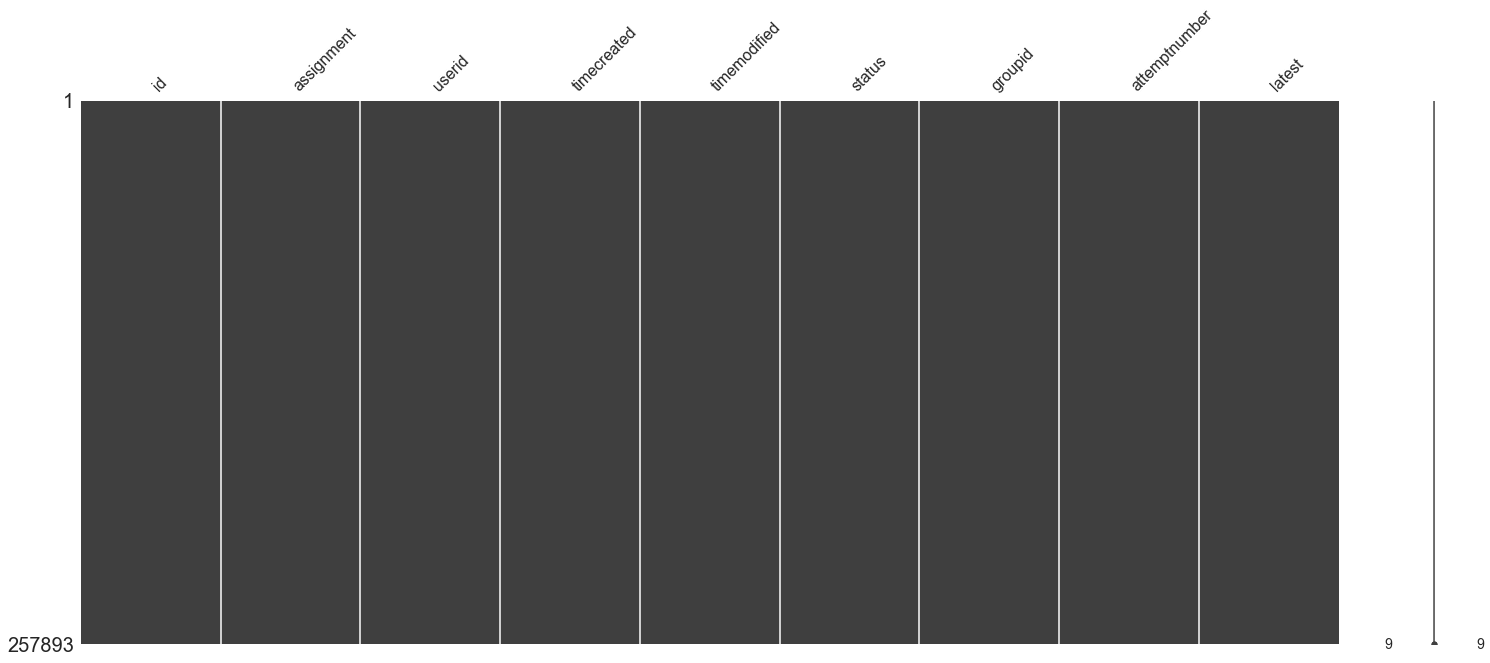

In [254]:
msno.matrix(assignment_submission)

In [255]:
assignment_submission_v2 = assignment_submission.sort_values(by='userid')
assignment_submission_v2

id  assignment  userid  timecreated  timemodified     status  \
113371  137193        9053       0   1553156112    1555050215  submitted   
219156  233870       12131       0   1558096516    1558576142  submitted   
153065  177581       10358       0   1555124469    1556798229  submitted   
47421   103296        7216       0   1551409245    1553185833  submitted   
153079  177617       10112       0   1555126983    1555126983        new   
...        ...         ...     ...          ...           ...        ...   
257250  281916       13155   28214   1561682576    1561682576        new   
257251  281917       13154   28214   1561682600    1561682600        new   
257485  282148       13167   28216   1561902240    1561902240        new   
257262  281929       13155   28223   1561688215    1561688215        new   
257255  281921       13155   28224   1561685563    1561685563        new   

        groupid  attemptnumber  latest  
113371    83567              0       1  
219156    77542              0       1  
153065    72115              0       1  
47421     70860              0       1  
153079    82884              0       1  
...         ...            ...     ...  
257250        0              0       1  
257251        0              0       1  
257485        0              0       1  
257262        0              0       1  
257255        0              0       1  

[257893 rows x 9 columns]

In [256]:
#shape of dataframe
print(assignment_submission_v2.shape)

#number of unique ids
print("id's:",assignment_submission_v2.id.nunique())

#number of unique users
print("userid's:",assignment_submission_v2.userid.nunique())

#number of unique assignments
print("assignments:",assignment_submission_v2.assignment.nunique())

#number of unique groupid's
print("groupid's:",assignment_submission_v2.groupid.nunique())

print('')

#number of submissions, drafts, etc
print('Status types')
print(assignment_submission_v2.status.value_counts())

print('')

#number of unique attemptnumbers
print(assignment_submission_v2.attemptnumber.value_counts())

(257893, 9)
id's: 257893
userid's: 19316
assignments: 8837
groupid's: 1132

Status types
submitted    160054
new           93595
draft          4231
reopened         13
Name: status, dtype: int64

0    257837
1        55
2         1
Name: attemptnumber, dtype: int64


Therefore, number of userid's in assignment_submission is greater than number of userid's in assignment_grades. So, everyone had not been graded?

Shah: Maybe some of the assignments are not graded online.

## Number of assignments per user

In [257]:
assignment_submitted_per_user = items_per_user(assignment_submission_v2, 'assignment')

In [258]:
assignment_submitted_per_user

userid  number_of_assignments
0           0                    509
1           5                      5
2           6                      6
3           7                     10
4           9                      9
...       ...                    ...
19311   28206                      3
19312   28214                      2
19313   28216                      1
19314   28223                      1
19315   28224                      1

[19316 rows x 2 columns]

In [259]:
fig = px.scatter(assignment_submitted_per_user,
                 x="userid",
                 y="number_of_assignments",
                 color="number_of_assignments",
                 template=template)
fig.show()

In [260]:
assignment_submitted_per_user.describe()

userid  number_of_assignments
count  19316.000000           19316.000000
mean   11790.219300              13.243218
std     7003.612567              14.217674
min        0.000000               1.000000
25%     6020.750000               4.000000
50%    11312.500000               9.000000
75%    16880.250000              17.000000
max    28224.000000             509.000000

# Assignment user mapping

In [261]:
assignment_user_mapping

id  assignment  userid
0            1         378    3009
1            2         378    3119
2            3         378    3213
3            4         378    3004
4            5         378    3006
...        ...         ...     ...
545820  610345        5800   17253
545821  610346        5799   17253
545822  610347        5798   17253
545823  610348        5797   17253
545824  610349        5796   17253

[545825 rows x 3 columns]

In [262]:
#number of unique id's
print(assignment_user_mapping.id.nunique())

#number of unique userid's
print(assignment_user_mapping.userid.nunique())

#number of unique assignments
print(assignment_user_mapping.assignment.nunique())

545825
18882
6733


Comparing this dataframe to the assignment submissions and assignment grade tables, this dataframe has less number of assignments.

In [263]:
assignment_user_mapping.describe()

id     assignment         userid
count  545825.000000  545825.000000  545825.000000
mean   328034.419825    8051.519837   11154.102016
std    170478.528129    3743.667159    5806.815164
min         1.000000      25.000000      32.000000
25%    197377.000000    4253.000000    5482.000000
50%    336115.000000    8996.000000   11377.000000
75%    473556.000000   11231.000000   16012.000000
max    610349.000000   13176.000000   28218.000000

## Number of assignments per user

In [264]:
assignment_per_user_usermapping = items_per_user(assignment_user_mapping, "assignment")

In [265]:
assignment_per_user_usermapping

userid  number_of_assignments
0          32                      2
1          58                      2
2          64                     34
3          65                     34
4          66                     51
...       ...                    ...
18877   28214                      1
18878   28215                      1
18879   28216                      1
18880   28217                      1
18881   28218                      1

[18882 rows x 2 columns]

In [266]:
fig = px.scatter(assignment_per_user_usermapping,
                 x="userid",
                 y="number_of_assignments",
                 color="number_of_assignments",
                 template=template)
fig.show()

In [267]:
assignment_per_user_usermapping.describe()

userid  number_of_assignments
count  18882.000000           18882.000000
mean   12145.869929              28.907160
std     6760.306066              36.731127
min       32.000000               1.000000
25%     6529.250000               5.000000
50%    11661.500000              16.000000
75%    17022.750000              43.000000
max    28218.000000             263.000000

# Merging the assignment metadata and assignment grades

In [268]:
assign_meta

id  course                                               name  grade
0          1       4                               Write an inline text    100
1          2       4  Dropbox Paper Submission - Meaning making in p...    100
2          3       4                     Building defect knowledge game    100
3          4       4                             Defect portfolio video    100
4          5       4              Defect Presentation 11th October 2017    100
...      ...     ...                                                ...    ...
11026  13182    1613                                         Assignment    100
11027  13183    1613                                            Imtihan    100
11028  13184    1613                               Imtihan Fiqih Ibadat    100
11029  10916    3799  Group Assignment - Final Report Submission (Gr...    100
11030  11613    3805                 Submission Individual assignment 1     10

[11031 rows x 4 columns]

In [269]:
assignment_grades

id  assignment  userid  timecreated  timemodified  grader  grade  \
0            1         378    3213   1536750002    1536749769       2   -1.0   
1            2         378    3006   1536750003    1536749811       2   -1.0   
2            3         378    3119   1536750003    1536749816       2   -1.0   
3            4         378    3118   1536750004    1536749821       2   -1.0   
4            5         378    3005   1536750004    1536749950       2   -1.0   
...        ...         ...     ...          ...           ...     ...    ...   
166096  180948        7155   20184   1605666483    1605666802     926   17.0   
166097  180947        7151   20184   1605666162    1605667397     926   30.0   
166098  180949        7579   11065   1605667904    1605668029     926   10.0   
166099  180950        7579   19157   1605668115    1560900678     926   -1.0   
166100  180951       12919   12071   1616025641    1616025641     544   -1.0   

        attemptnumber  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
166096              0  
166097              0  
166098              0  
166099              0  
166100              0  

[166101 rows x 8 columns]

Renaming the id column in assign_meta

In [270]:
assign_meta.rename(columns={'id':'assignment'},inplace=True)

C:\Users\kople\AppData\Local\Temp\ipykernel_22896\1083333104.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [271]:
assignment_consolidated = assignment_grades.merge(assign_meta, on='assignment',how='inner').drop(columns=['timecreated','timemodified','grader'])

In [272]:
assignment_consolidated

id  assignment  userid  grade_x  attemptnumber  course  \
0            1         378    3213     -1.0              0     157   
1            2         378    3006     -1.0              0     157   
2            3         378    3119     -1.0              0     157   
3            4         378    3118     -1.0              0     157   
4            5         378    3005     -1.0              0     157   
...        ...         ...     ...      ...            ...     ...   
166096  180932       13160    3235     -1.0              0    4531   
166097  180934       13160   18777     -1.0              0    4531   
166098  180890       13176    8956     -1.0              0    3807   
166099  180949        7579   11065     10.0              0    4179   
166100  180950        7579   19157     -1.0              0    4179   

                                       name  grade_y  
0       What does the LIBRARY mean to you?       100  
1       What does the LIBRARY mean to you?       100  
2       What does the LIBRARY mean to you?       100  
3       What does the LIBRARY mean to you?       100  
4       What does the LIBRARY mean to you?       100  
...                                     ...      ...  
166096                         Assignment 2       10  
166097                         Assignment 2       10  
166098                    Test Marks Doubts      100  
166099                         Assignment 1      100  
166100                         Assignment 1      100  

[166101 rows x 8 columns]

In [273]:
assignment_consolidated.rename(columns={'grade_x':'grade_obtained','grade_y':'grademax'},inplace=True)

In [274]:
assignment_consolidated

id  assignment  userid  grade_obtained  attemptnumber  course  \
0            1         378    3213            -1.0              0     157   
1            2         378    3006            -1.0              0     157   
2            3         378    3119            -1.0              0     157   
3            4         378    3118            -1.0              0     157   
4            5         378    3005            -1.0              0     157   
...        ...         ...     ...             ...            ...     ...   
166096  180932       13160    3235            -1.0              0    4531   
166097  180934       13160   18777            -1.0              0    4531   
166098  180890       13176    8956            -1.0              0    3807   
166099  180949        7579   11065            10.0              0    4179   
166100  180950        7579   19157            -1.0              0    4179   

                                       name  grademax  
0       What does the LIBRARY mean to you?        100  
1       What does the LIBRARY mean to you?        100  
2       What does the LIBRARY mean to you?        100  
3       What does the LIBRARY mean to you?        100  
4       What does the LIBRARY mean to you?        100  
...                                     ...       ...  
166096                         Assignment 2        10  
166097                         Assignment 2        10  
166098                    Test Marks Doubts       100  
166099                         Assignment 1       100  
166100                         Assignment 1       100  

[166101 rows x 8 columns]

In [275]:
# rearranging the columns
assignment_consolidated = assignment_consolidated[['id','userid','assignment','course','name','attemptnumber','grademax','grade_obtained']]

In [276]:
assignment_consolidated

id  userid  assignment  course  \
0            1    3213         378     157   
1            2    3006         378     157   
2            3    3119         378     157   
3            4    3118         378     157   
4            5    3005         378     157   
...        ...     ...         ...     ...   
166096  180932    3235       13160    4531   
166097  180934   18777       13160    4531   
166098  180890    8956       13176    3807   
166099  180949   11065        7579    4179   
166100  180950   19157        7579    4179   

                                       name  attemptnumber  grademax  \
0       What does the LIBRARY mean to you?               0       100   
1       What does the LIBRARY mean to you?               0       100   
2       What does the LIBRARY mean to you?               0       100   
3       What does the LIBRARY mean to you?               0       100   
4       What does the LIBRARY mean to you?               0       100   
...                                     ...            ...       ...   
166096                         Assignment 2              0        10   
166097                         Assignment 2              0        10   
166098                    Test Marks Doubts              0       100   
166099                         Assignment 1              0       100   
166100                         Assignment 1              0       100   

        grade_obtained  
0                 -1.0  
1                 -1.0  
2                 -1.0  
3                 -1.0  
4                 -1.0  
...                ...  
166096            -1.0  
166097            -1.0  
166098            -1.0  
166099            10.0  
166100            -1.0  

[166101 rows x 8 columns]

In [277]:
assignment_consolidated[assignment_consolidated.grade_obtained!=-1.0]

id  userid  assignment  course  \
468         61    7557         481    1647   
469         62    7558         481    1647   
470         63    7560         481    1647   
471         81   15424         481    1647   
472         65    7573         481    1647   
...        ...     ...         ...     ...   
166068  180511    5151        7692    3306   
166069  180513    2389        7692    3306   
166070  180512    1907        7692    3306   
166071  180510    5167        7692    3306   
166099  180949   11065        7579    4179   

                                           name  attemptnumber  grademax  \
468                   Class Test No.1 12/9/2018              0        10   
469                   Class Test No.1 12/9/2018              0        10   
470                   Class Test No.1 12/9/2018              0        10   
471                   Class Test No.1 12/9/2018              0        10   
472                   Class Test No.1 12/9/2018              0        10   
...                                         ...            ...       ...   
166068  TUTORIAL 5 (PPT & SHORT WRITEUP) 3/4/19              0        15   
166069  TUTORIAL 5 (PPT & SHORT WRITEUP) 3/4/19              0        15   
166070  TUTORIAL 5 (PPT & SHORT WRITEUP) 3/4/19              0        15   
166071  TUTORIAL 5 (PPT & SHORT WRITEUP) 3/4/19              0        15   
166099                             Assignment 1              0       100   

        grade_obtained  
468                6.0  
469                3.0  
470                7.0  
471                7.0  
472                6.0  
...                ...  
166068            10.8  
166069            10.8  
166070            10.2  
166071            10.2  
166099            10.0  

[16129 rows x 8 columns]

In [278]:
# assignment_consolidated.to_csv(f'{ppath}assignment_consolidated.csv')

## no of assignments per user

In [279]:
assignment_per_user = items_per_user(assignment_consolidated,'assignment')
assignment_per_user.to_csv(f'{ppath}assignment_per_user.csv')

# Course

In [280]:
course = pd.read_csv(f'{path}course.csv')
course

id  category  sortorder  \
0     5104        40      30001   
1     4298        18     390243   
2     5114        18     390005   
3     2440         3      50026   
4     3237         9     110051   
...    ...       ...        ...   
5176  4838        14     160062   
5177  3646         5      70016   
5178  3139        18     390314   
5179  1129        18     390802   
5180  4880        14     160021   

                                               fullname shortname  idnumber  \
0                             Enhancing Research Impact       ERI       ERI   
1     SIJ3004 Biokimia Klinikal Dan Fisiologi (Clini...   SIJ3004   SIJ3004   
2     CNU046 Korean Listening And Speaking 1 (Korean...    CNU046    CNU046   
3          GKN1001 Khidmat Komuniti (Community Service)   GKN1001   GKN1001   
4     EIE3007/ESEE3104 Rekabentuk Ujikaji (Experimen...   EIE3007   EIE3007   
...                                                 ...       ...       ...   
5176  MID3009 Kemahiran Kaunseling Untuk Jururawat (...   MID3009   MID3009   
5177  BID2008 Teknik Dan Metodologi Perancangan (Pla...   BID2008   BID2008   
5178  SHED3302 Kaedah Dalam Biologi Struktur (Struct...  SHED3302  SHED3302   
5179   SHED3203 Teknologi Mikrob (Microbial Technology)  SHED3203  SHED3203   
5180  MIC1004/MBEB1105 Mikrobiologi Perubatan Asas U...   MIC1004   MIC1004   

                                          summary  summaryformat  format  \
0                                             NaN              1  topics   
1       Session 2018/2019 Semester 2<br>(Group 1)              1  topics   
2       Session 2018/2019 Semester 2<br>(Group 1)              1  topics   
3     Session 2018/2019 Semester 2<br>(Group 1,2)              1  topics   
4                        <p>Session 2018/2019</p>              1  topics   
...                                           ...            ...     ...   
5176    Session 2018/2019 Semester 2<br>(Group 1)              1  topics   
5177    Session 2018/2019 Semester 2<br>(Group 1)              1  topics   
5178                 Session 2018/2019 Semester 1              1  topics   
5179                 Session 2018/2019 Semester 1              1  topics   
5180    Session 2018/2019 Semester 2<br>(Group 1)              1  topics   

      showgrades  ...  defaultgroupingid  lang  calendartype  theme  \
0              1  ...                  0   NaN           NaN    NaN   
1              1  ...                  0   NaN           NaN    NaN   
2              1  ...                  0   NaN           NaN    NaN   
3              1  ...                  0   NaN           NaN    NaN   
4              1  ...                  0   NaN           NaN    NaN   
...          ...  ...                ...   ...           ...    ...   
5176           1  ...                  0   NaN           NaN    NaN   
5177           1  ...                  0   NaN           NaN    NaN   
5178           1  ...                  0   NaN           NaN    NaN   
5179           1  ...                  0   NaN           NaN    NaN   
5180           1  ...                  0   NaN           NaN    NaN   

      timecreated  timemodified  requested  enablecompletion  \
0      1555295477    1555295477          0                 1   
1               0             0          0                 0   
2               0             0          0                 0   
3               0             0          0                 0   
4      1548403431    1548403431          0                 1   
...           ...           ...        ...               ...   
5176            0             0          0                 0   
5177            0    1550732436          0                 0   
5178            0             0          0                 0   
5179            0             0          0                 0   
5180            0    1550450671          0                 0   

      completionnotify    cacherev  
0                    0  1555301229  
1                    0  15605

In [281]:
course.dtypes

id                     int64
category               int64
sortorder              int64
fullname              object
shortname             object
idnumber              object
summary               object
summaryformat          int64
format                object
showgrades             int64
newsitems              int64
startdate              int64
enddate                int64
marker                 int64
maxbytes               int64
legacyfiles            int64
showreports            int64
visible                int64
visibleold             int64
groupmode              int64
groupmodeforce         int64
defaultgroupingid      int64
lang                  object
calendartype         float64
theme                float64
timecreated            int64
timemodified           int64
requested              int64
enablecompletion       int64
completionnotify       int64
cacherev               int64
dtype: object

In [282]:
course.id.nunique()

5181

Therefore all the id's are unique, which means we can set it as the index

In [283]:
#course.set_index('id', inplace=True)

In [284]:
#course.sort_index(inplace=True)

In [285]:
#course

Checking the categories

In [286]:
course.sort_values(by='category').category.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 32, 34, 35, 36, 37, 39,
       40, 41, 43, 46], dtype=int64)

In [287]:
course.category.nunique()

38

Note: id's: 29,30,31,42,44,45 do not exist

In [288]:
print(course.format.value_counts())

topics            5056
grid                53
flexsections        36
weeks               23
singleactivity      10
socialwall           1
social               1
site                 1
Name: format, dtype: int64


## Course Category

In [289]:
course_category = pd.read_csv(f'{path}course_categories.csv')

In [290]:
course_category

id                                               name     idnumber  \
0   19  Faculty of Computer Science & Information Tech...            W   
1    7                                    Cultural Centre            R   
2   12               Faculty of Languages and Linguistics            T   
3   40                                            Epigeum          NaN   
4   11                             Faculty of Engineering            K   
5   13                                     Faculty of Law            L   
6    4                Faculty of Arts and Social Sciences            A   
7    6                Faculty of Business and Accountancy            C   
8   26                           Undergraduate Programmes       FOM_UG   
9   21                      Foundation of Islamic Studies           NP   
10  22                                               SKET            O   
11  23                           Academy of Malay Studies            J   
12  24                Institute of Educational Leadership            Y   
13  45                                        S2migration          NaN   
14  25                                               ADEC         ADEC   
15  10                               Faculty of Education            P   
16  14                                Faculty of Medicine            M   
17  18                                 Faculty of Science            S   
18   2                      Foundation Studies in Science            F   
19  27                            Postgraduate Programmes       FOM_PG   
20   1                                      Miscellaneous          NaN   
21   9              Faculty of Economics & Administration            E   
22   3                                         University            G   
23   5                        Faculty of Built Enviroment            B   
24  20                         Academy of Islamic Studies            I   
25  28       Bachelor of Medicine and Bachelor of Surgery         MBBS   
26   8                               Faculty of Dentistry            D   
27  39                        Faculty Development Program       FOMFDP   
28  15                                   Graduate Studies            H   
29  16                                             INPUMA            Z   
30  17                                       Sport Centre            V   
31  31                                    UMMP Curriculum          NaN   
32  38                     BLOCK 1 - Language in Medicine          NaN   
33  35                                   UMMP Assessment           NaN   
34  33                       UMMP Course Forms - Proforma          NaN   
35  34                               UMMP - POC & Archive          NaN   
36  46                                        s1Migration  s1Migration   
37  30      University of Malaya Medical Programme (UMMP)         UMMP   
38  41  MIA 3001: PRACTICE OF CLINICAL MEDICINE 1; STA...          NaN   
39  32                                    UMMP Evaluation          NaN   
40  42  MIA 5001 : PRACTICE OF CLINICAL MEDICINE 3; ST...          NaN   
41  43  MIA 4001 : PRACTICE OF CLINICAL MEDICINE 2; ST...          NaN   
42  36  MIA1001: MEDICAL SCIENCES 1 ; STAGE 1 [ BLOCK ...          NaN   
43  37  MIA 2001: MEDICAL SCIENCES 2; STAGE 2 [ BLOCK ...          NaN   
44  44                                        S1migration          NaN   

                                          description  descriptionformat  \
0   <p>Faculty of Computer Science &amp; Informati...                  1   
1                              <p>Cultural Centre</p>                  1   
2         <p>Faculty of Languages and Linguistics</p>                  1   
3                                                 NaN                  1   
4                       <p>Faculty of Engineering</p>                  1   
5                               <p>Faculty of Law</p>                  1   
6          <p>Faculty of Arts and Social Sciences</p>              

In [291]:
course_category.id.nunique()

45

In [292]:
#course_category.set_index('id',inplace=True,drop=True)

In [293]:
#course_category

In [294]:
#course_category.sort_index(inplace=True)

In [295]:
#course

In [296]:
course_category.index.unique()

RangeIndex(start=0, stop=45, step=1)

Note: id 29 doesn't exist

# Course module completion

In [297]:
course_completion = pd.read_csv(f'{path}course_module_completion.csv')
course_completion

id  coursemoduleid  userid  completionstate  viewed  timemodified
0         55            7475   14638                1       1    1536767923
1          2            6182       6                1       1    1536674375
2          3            6211       6                1       1    1536719141
3          4            6211    6135                1       1    1536719704
4          5            6211    6136                1       1    1536719740
...      ...             ...     ...              ...     ...           ...
40721  42809          142558    1062                0       0    1605582372
40722  42810           82549    2652                1       1    1615354136
40723  42811           82551    2652                1       1    1615354155
40724  42812           86671    2652                1       1    1615354188
40725  42813           86675    2652                1       1    1615354194

[40726 rows x 6 columns]

In [298]:
course_completion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40726 entries, 0 to 40725
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               40726 non-null  int64
 1   coursemoduleid   40726 non-null  int64
 2   userid           40726 non-null  int64
 3   completionstate  40726 non-null  int64
 4   viewed           40726 non-null  int64
 5   timemodified     40726 non-null  int64
dtypes: int64(6)
memory usage: 1.9 MB


In [299]:
#number of unique courses
print(course_completion.coursemoduleid.nunique())

#number of unique users
print(course_completion.userid.nunique())

#checking if users have not completed courses
print(course_completion.completionstate.value_counts())

1827
2915
1    39745
0      980
2        1
Name: completionstate, dtype: int64


 (Not enough data)
Therefore, 980 students have not completed the course. Begs the question; is this data referring to the course completion survey? This would be true if the table is set up so that if a user has completed the survey, the completionstate becomes 1.

Another question: Are the 980 users actually instructors?

2915 students completed 1827 courses

Therefore, users have completed more than 50 courses! Is this the data that indicates how many courses a student has completed over the entire degree?

# Assignment Feedback

In [300]:
assignment_feedback = pd.read_csv(f'{path}assignfeedback_files.csv')
assignment_feedback

id  assignment   grade  numfiles
0      1        1807   11632         1
1      2        1807   11585         1
2      3        1807   11547         1
3      4        1807   11695         1
4      5        1807   11784         1
..   ...         ...     ...       ...
510  558       11761  136933         1
511  559       11761  136234         1
512  560       11763  138152         1
513  561       11763  138403         1
514  557       11761  138311         1

[515 rows x 4 columns]

In [301]:
#number of unique assignments
print(assignment_feedback.assignment.nunique())

#number of unique grades
print(assignment_feedback.grade.nunique())

print('')

#number of unique numfiles
print(assignment_feedback.numfiles.value_counts())

46
515

1    481
0     34
Name: numfiles, dtype: int64


Confusing data; how can there be 515 different grades? Is this not referring to grades? Because a grade cannot be a 3 or 3 digit number, as is seen in the grade column.

# forum posts

In [302]:
forumposts = pd.read_csv(f'{path}forum_posts.csv')
forumposts

id  discussion  parent  userid     created    modified  mailed  \
0       8618        3816    7178    4743  1540747317  1540747317       1   
1      24525       13185   24524    7404  1551772328  1551772328       1   
2      20948       10939   20917    5766  1550627084  1550627084       1   
3         28          28       0     211  1536248718  1536248718       1   
4       6418        3426       0    6385  1539622370  1539622370       1   
...      ...         ...     ...     ...         ...         ...     ...   
47365  54088       28531       0     521  1577768621  1577768621       0   
47366  54092       18792   35138   10609  1605842471  1605842471       0   
47367  54089       28532       0     521  1577768633  1577768633       0   
47368  54093       18792   35145   10609  1605842588  1605842588       0   
47369  54090       18792   35181   10609  1605838598  1605842651       0   

                                                 subject  \
0                                          Re: my fav ad   
1                                    Re: Halaqah 2 (5/3)   
2      Re: Three main takeaways from all session atte...   
3                                          Tutorial slot   
4                                             tutorial 4   
...                                                  ...   
47365                                              TEST2   
47366                                       Re: Kuliah 7   
47367                                              TEST3   
47368                                       Re: Kuliah 7   
47369              Re: Kuliah 7 - Benchmark in Education   

                                                 message  messageformat  \
0                      <p>Wow, it's very creative XD</p>              1   
1                                 <p>Ms 56 ali imran</p>              1   
2      <p>1. There is still flaws in our urban legisl...              1   
3      <p>Please note that tutorials will be conducte...              1   
4                                      <p>tutorial 4</p>              1   
...                                                  ...            ...   
47365                                    <p>SJEM3260</p>              1   
47366  <p>Yes, you have defined correctly. Bur the qu...              1   
47367                                    <p>SJEM3260</p>              1   
47368  <p>Yes you are partially right. But UM has som...              1   
47369  <p>yes you are right. But what are those QS cr...              1   

       messagetrust  attachment  totalscore  mailnow  
0                 0         NaN           0        0  
1                 0         1.0           0        0  
2                 0         NaN           0        0  
3                 0         NaN           0        0  
4                 0         1.0           0        0  
...             ...         ...         ...      ...  
47365             0         NaN           0        0  
47366             0         NaN           0        0  
47367             0         NaN           0        0  
47368             0         NaN           0        0  
47369             0         NaN           0        0  

[47370 rows x 14 columns]

<AxesSubplot:>

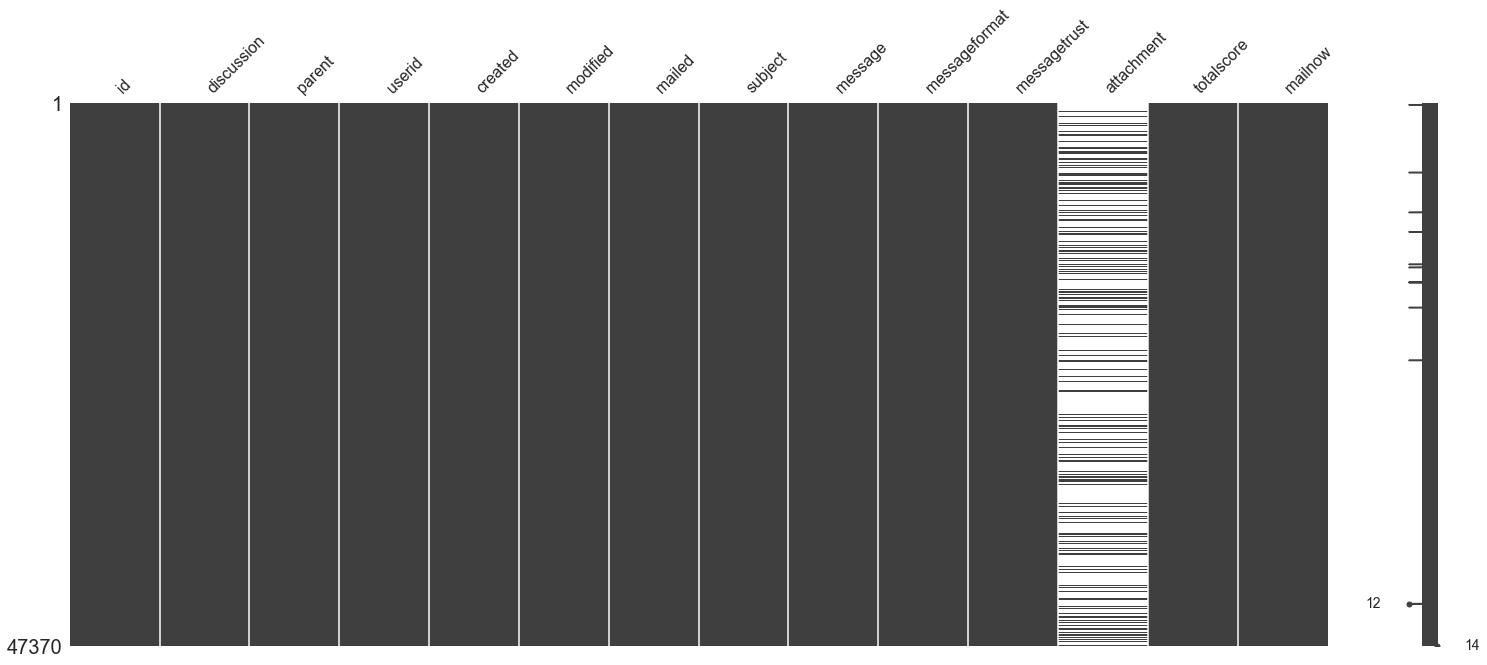

In [303]:
msno.matrix(forumposts)

In [304]:
courses_per_user = items_per_user(course_completion, "coursemoduleid")
courses_per_user

userid  number_of_coursemoduleids
0          6                         43
1          7                          7
2         32                         11
3         38                          1
4         58                         59
...      ...                        ...
2910   26864                          1
2911   27087                          1
2912   27433                          1
2913   27602                          1
2914   28178                          1

[2915 rows x 2 columns]

In [305]:
#checking if there are blank messages
forumposts[forumposts.message==' ']

Empty DataFrame
Columns: [id, discussion, parent, userid, created, modified, mailed, subject, message, messageformat, messagetrust, attachment, totalscore, mailnow]
Index: []

Therefore, there are no blank messages.

In [306]:
forumposts.sort_values(by='discussion', inplace=True)
forumposts

id  discussion  parent  userid     created    modified  mailed  \
26         1           1       0     101  1536031123  1536032462       1   
24         5           5       0     101  1536038343  1536038343       1   
23         8           8       0     753  1536039133  1536039133       1   
22        10          10       0      86  1536073043  1536073043       1   
4425    3765          12    3654    1050  1538663955  1538663955       1   
...      ...         ...     ...     ...         ...         ...     ...   
47360  54085       28528       0     521  1577768351  1577768351       0   
47362  54086       28529       0     521  1577768367  1577768367       0   
47363  54087       28530       0     521  1577768604  1577768604       0   
47365  54088       28531       0     521  1577768621  1577768621       0   
47367  54089       28532       0     521  1577768633  1577768633       0   

                                                subject  \
26                  Important Announcement for WIX1001    
24                                  Groups and Lectures   
23                     CIB 2002 CLASS - SEM1, 2018/2019   
22                            Attn to: Group 5 & 6 only   
4425   Re: Why China Is an Attractive Market for Export   
...                                                 ...   
47360                                              TEST   
47362                                        ASSIGNMENT   
47363                                             TEST1   
47365                                             TEST2   
47367                                             TEST3   

                                                 message  messageformat  \
26     <p>Please Note that 10/9 and 17/9 are Public H...              1   
24     <p>Group 1 Monday, 10-12am - AQMS DK1<br />Gro...              1   
23     <p>SALAM &amp; HI</p>\r\n<p>Welcome to CIB 200...              1   
22     <p>Dear students,</p>\r\n<p>My class will star...              1   
4425   <p>Thank for the sharing.  The real world is n...              1   
...                                                  ...            ...   
47360                                    <p>SJEM2254</p>              1   
47362                                    <p>SJEM2254</p>              1   
47363                                    <p>SJEM3260</p>              1   
47365                                    <p>SJEM3260</p>              1   
47367                                    <p>SJEM3260</p>              1   

       messagetrust  attachment  totalscore  mailnow  
26                0         NaN           0        0  
24                0         NaN           0        1  
23                0         NaN           0        0  
22                0         NaN           0        0  
4425              0         NaN           0        0  
...             ...         ...         ...      ...  
47360             0         NaN           0        0  
47362             0         NaN           0        0  
47363             0         NaN           0        0  
47365             0         NaN           0        0  
47367             0         NaN           0        0  

[47370 rows x 14 columns]

This table does not distinguish between instructors and students when labelling the userid column. This needs to be solved.

Shah: I think we need to select only students (from userid). That way we can identify how active each student used the forum

A possible solution is to use the mdl_user table and extract data that have @siswa in the email field. These will be the students. Eventually, joining all the tables we need by the userid (of the students)

In [307]:
#number of unique discussions
print(forumposts.discussion.nunique())

#number of unique userid's
print(forumposts.userid.nunique())

#number of unique message formats
print(forumposts.messageformat.nunique())

print('')

#number of non null values in attachments
print(forumposts.attachment.notna().sum())

#number of null values in attachments
print(forumposts.attachment.isna().sum())

#number of non null values in message
print(forumposts.message.notna().sum())

#number of null values in message
print(forumposts.message.isna().sum())

25907
9815
1

12041
35329
47358
12


The students that attached something are more engaged? This will be true if either they were asked to attach sth or if the discussion is such that it encourages attachments. e.g. a discussion asking students about their emails does not encourage attachment. On the other hand, a discussion about fossil fuels might. 
Becomes too complex to implement the aforementioned process. Will require text classification.

## Number of messages per userid

We can't use the items_per_user() function here because we're dealing with strings here. Not numbers

In [308]:
users_forumposts = forumposts.sort_values(by='userid').userid.unique()
users_forumposts

array([    6,     7,     8, ..., 26687, 26729, 26873], dtype=int64)

In [309]:
nmessages_peruser_forumposts = []
for user in users_forumposts:
    #select user from the table,count number of messages and store result
    n_messages=forumposts[forumposts.userid==user].message.notna().sum(axis=0)
    #append result to array
    nmessages_peruser_forumposts.append(n_messages)
    #print the result                                                           
    #print('userid ',user,'sent ',n_messages,' messages')

In [310]:
messages_peruser_forumposts = pd.DataFrame({'userid':users_forumposts,'number of messages':nmessages_peruser_forumposts})
messages_peruser_forumposts

userid  number of messages
0          6                  31
1          7                   1
2          8                  10
3          9                   8
4         10                   5
...      ...                 ...
9810   26641                   2
9811   26671                   1
9812   26687                   2
9813   26729                   1
9814   26873                   4

[9815 rows x 2 columns]

In [311]:
fig = px.scatter(messages_peruser_forumposts,
                 x="userid",
                 y="number of messages",
                 color="number of messages",
                 template=template)
fig.show()

In [312]:
post_per_student = items_per_user(forumposts,'id')

In [313]:
post_per_student

userid  number_of_ids
0          6             31
1          7              1
2          8             10
3          9              8
4         10              5
...      ...            ...
9810   26641              2
9811   26671              1
9812   26687              2
9813   26729              1
9814   26873              4

[9815 rows x 2 columns]

In [314]:
fig = px.scatter(post_per_student,
                 x="userid",
                 y="number_of_ids",
                 color="number_of_ids",
                 template=template)
fig.show()

# Grades

In [315]:
grades = pd.read_csv(f'{path}grades.csv')

In [316]:
grades.head()


id  itemid  userid  rawgrade  rawgrademax  rawgrademin  rawscaleid  \
0  48156    4690   16356       NaN        100.0          0.0         NaN   
1  22563    1459    3058       NaN        100.0          0.0         NaN   
2    407     630    4720       NaN        100.0          0.0         NaN   
3    386     629    1948       NaN        100.0          0.0         NaN   
4    387     630    1948       NaN        100.0          0.0         NaN   

   usermodified  finalgrade  hidden  ...  overridden  excluded  feedback  \
0       16356.0         NaN       0  ...           0         0       NaN   
1           NaN       100.0       0  ...           0         0       NaN   
2        4720.0         NaN       0  ...           0         0       NaN   
3           NaN         NaN       0  ...           0         0       NaN   
4           NaN         NaN       0  ...           0         0       NaN   

   feedbackformat  information informationformat   timecreated  timemodified  \
0               0          NaN                 0  1.539539e+09           NaN   
1               0          NaN                 0           NaN  1.538378e+09   
2               0          NaN                 0  1.544367e+09           NaN   
3               0          NaN                 0           NaN           NaN   
4               0          NaN                 0           NaN           NaN   

   aggregationstatus  aggregationweight  
0            novalue                0.0  
1            unknown                NaN  
2            novalue                0.0  
3            novalue                0.0  
4            novalue                0.0  

[5 rows x 23 columns]

In [317]:
grades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223314 entries, 0 to 1223313
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1223314 non-null  int64  
 1   itemid             1223314 non-null  int64  
 2   userid             1223314 non-null  int64  
 3   rawgrade           80056 non-null    float64
 4   rawgrademax        1223314 non-null  float64
 5   rawgrademin        1223314 non-null  float64
 6   rawscaleid         252 non-null      float64
 7   usermodified       239558 non-null   float64
 8   finalgrade         113636 non-null   float64
 9   hidden             1223314 non-null  int64  
 10  locked             1223314 non-null  int64  
 11  locktime           1223314 non-null  int64  
 12  exported           1223314 non-null  int64  
 13  overridden         1223314 non-null  int64  
 14  excluded           1223314 non-null  int64  
 15  feedback           3044 non-null

In [318]:
grades.describe()

id        itemid        userid      rawgrade   rawgrademax  \
count  1.223314e+06  1.223314e+06  1.223314e+06  80056.000000  1.223314e+06   
mean   8.050681e+05  1.408961e+04  1.184431e+04     25.101277  7.958312e+01   
std    4.060868e+05  6.485650e+03  6.357090e+03     32.691182  4.041421e+01   
min    1.800000e+01  1.900000e+01  5.000000e+00      0.000000  0.000000e+00   
25%    4.881562e+05  8.762000e+03  6.108000e+03      8.000000  1.000000e+02   
50%    8.223105e+05  1.685900e+04  1.219500e+04     10.000000  1.000000e+02   
75%    1.142621e+06  1.976200e+04  1.638400e+04     20.000000  1.000000e+02   
max    1.481988e+06  2.322000e+04  2.821700e+04    850.000000  2.600000e+03   

        rawgrademin  rawscaleid   usermodified     finalgrade        hidden  \
count  1.223314e+06  252.000000  239558.000000  113636.000000  1.223314e+06   
mean   3.768452e-04    1.805556   10282.247973      36.303812  7.896583e-04   
std    1.940885e-02    0.854965    6734.282363      63.021061  2.808977e-02   
min    0.000000e+00    1.000000       2.000000       0.000000  0.000000e+00   
25%    0.000000e+00    1.000000    4830.000000       8.500000  0.000000e+00   
50%    0.000000e+00    2.000000    9295.000000      10.000000  0.000000e+00   
75%    0.000000e+00    2.000000   14947.750000      63.514250  0.000000e+00   
max    1.000000e+00    5.000000   28217.000000    2550.000000  1.000000e+00   

       ...   locktime   exported    overridden   excluded  feedbackformat  \
count  ...  1223314.0  1223314.0  1.223314e+06  1223314.0    1.223314e+06   
mean   ...        0.0        0.0  2.307104e+06        0.0    4.258923e-03   
std    ...        0.0        0.0  5.981915e+07        0.0    6.512133e-02   
min    ...        0.0        0.0  0.000000e+00        0.0    0.000000e+00   
25%    ...        0.0        0.0  0.000000e+00        0.0    0.000000e+00   
50%    ...        0.0        0.0  0.000000e+00        0.0    0.000000e+00   
75%    ...        0.0        0.0  0.000000e+00        0.0    0.000000e+00   
max    ...        0.0        0.0  1.560990e+09        0.0    1.000000e+00   

       information  informationformat   timecreated  timemodified  \
count          0.0          1223314.0  1.999210e+05  1.156050e+05   
mean           NaN                0.0  1.552918e+09  1.553327e+09   
std            NaN                0.0  6.335991e+06  6.288772e+06   
min            NaN                0.0  1.536742e+09  1.536553e+09   
25%            NaN                0.0  1.550996e+09  1.550558e+09   
50%            NaN                0.0  1.554713e+09  1.554866e+09   
75%            NaN                0.0  1.557907e+09  1.558377e+09   
max            NaN                0.0  1.566041e+09  1.605668e+09   

       aggregationweight  
count       1.136849e+06  
mean        2.707704e-02  
std         1.382681e-01  
min         0.000000e+00  
25%         0.000000e+00  
50%         0.000000e+00  
75%         0.000000e+00  
max         1.000000e+00  

[8 rows x 21 columns]

In [319]:
grades.sort_values(by='id')

id  itemid  userid  rawgrade  rawgrademax  rawgrademin  \
10            18     406    8543       NaN        100.0          0.0   
12            20     406    8736       NaN        100.0          0.0   
13            22     406    8722       NaN        100.0          0.0   
15            24     406    8614       NaN        100.0          0.0   
18            26     406    8536       NaN        100.0          0.0   
...          ...     ...     ...       ...          ...          ...   
1223308  1481984   20285   18767       NaN        100.0          0.0   
1223309  1481985   20287   18767       NaN        100.0          0.0   
1223311  1481986   21126   18767       NaN        100.0          0.0   
1223312  1481987   21461   18767       NaN        100.0          0.0   
1223313  1481988   23212   18767       NaN         30.0          0.0   

         rawscaleid  usermodified  finalgrade  hidden  ...  overridden  \
10              NaN           NaN         NaN       0  ...           0   
12              NaN           NaN         NaN       0  ...           0   
13              NaN           NaN         NaN       0  ...           0   
15              NaN           NaN         NaN       0  ...           0   
18              NaN           NaN         NaN       0  ...           0   
...             ...           ...         ...     ...  ...         ...   
1223308         NaN           NaN         NaN       0  ...           0   
1223309         NaN           NaN         NaN       0  ...           0   
1223311         NaN           NaN         NaN       0  ...           0   
1223312         NaN           NaN         NaN       0  ...           0   
1223313         NaN           NaN         NaN       0  ...           0   

         excluded  feedback  feedbackformat  information informationformat  \
10              0       NaN               0          NaN                 0   
12              0       NaN               0          NaN                 0   
13              0       NaN               0          NaN                 0   
15              0       NaN               0          NaN                 0   
18              0       NaN               0          NaN                 0   
...           ...       ...             ...          ...               ...   
1223308         0       NaN               0          NaN                 0   
1223309         0       NaN               0          NaN                 0   
1223311         0       NaN               0          NaN                 0   
1223312         0       NaN               0          NaN                 0   
1223313         0       NaN               0          NaN                 0   

         timecreated  timemodified  aggregationstatus  aggregationweight  
10               NaN           NaN            unknown                NaN  
12               NaN           NaN            unknown                NaN  
13               NaN           NaN            unknown                NaN  
15               NaN           NaN            unknown                NaN  
18               NaN           NaN            unknown                NaN  
...              ...           ...                ...                ...  
1223308          NaN           NaN            novalue                0.0  
1223309          NaN           NaN            novalue                0.0  
1223311          NaN           NaN            novalue                0.0  
1223312          NaN           NaN            novalue                0.0  
1223313          NaN           NaN            novalue                0.0  

[1223314 rows x 23 columns]

In [320]:
#number of unique id's
print(grades.id.nunique())

#number of unique userid's
print(grades.userid.nunique())

#number of unique items
print(grades.itemid.nunique())

#
print(grades.finalgrade[grades.finalgrade>0].shape)

#shape of entire dataframe
print(grades.shape)

1223314
18697
14136
(111281,)
(1223314, 23)


<AxesSubplot:>

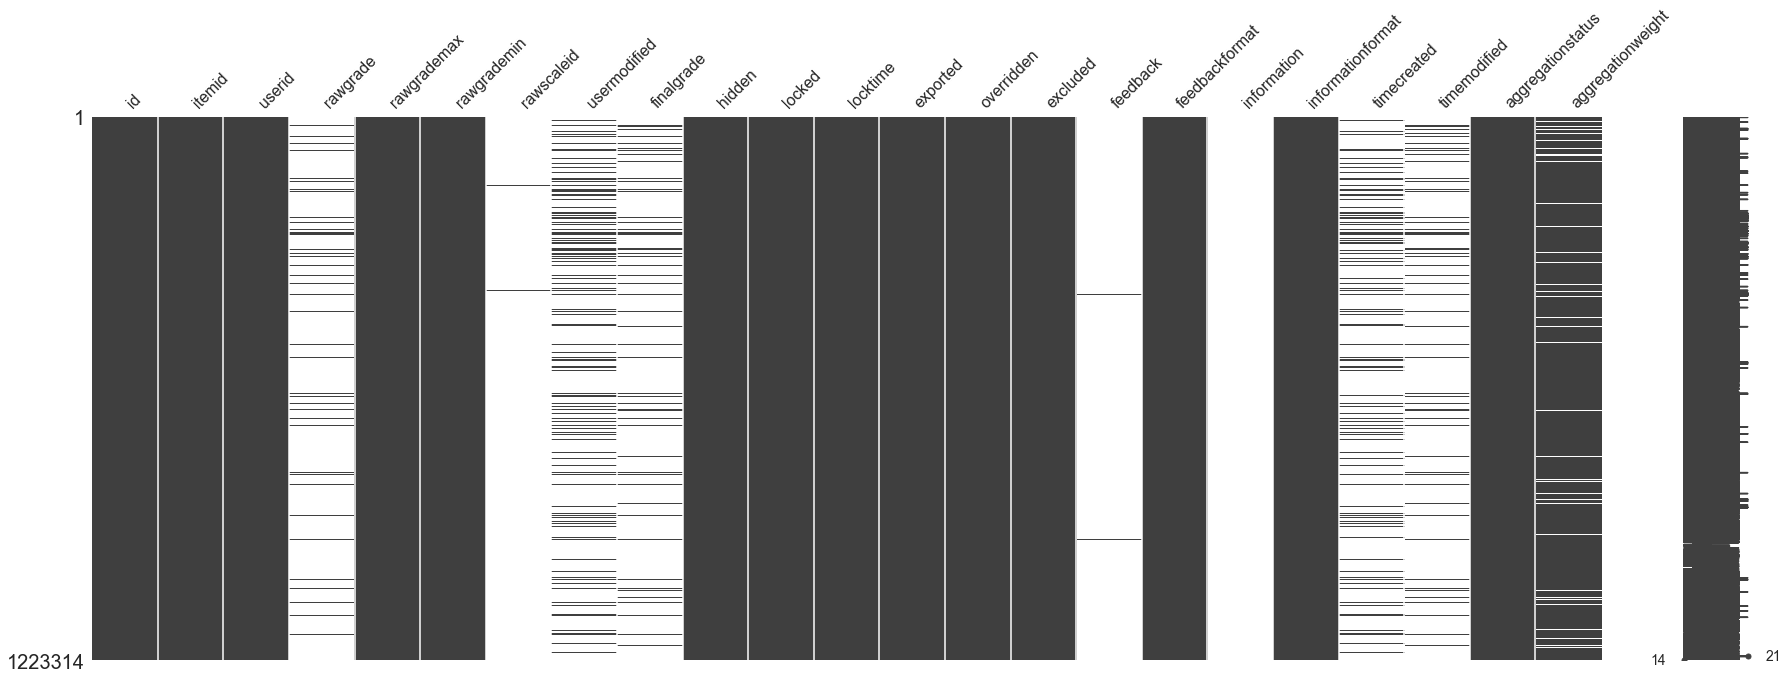

In [321]:
#missing data
msno.matrix(grades, figsize=(30,10))

The dataframe has a lot of missing values in different columns. So we have to select the portion that has valid grades.

In [322]:
#selecting the portion of the dataframe where the finalgrade values exist
grades=grades[grades["finalgrade"].notna()]
grades.shape

(113636, 23)

<AxesSubplot:>

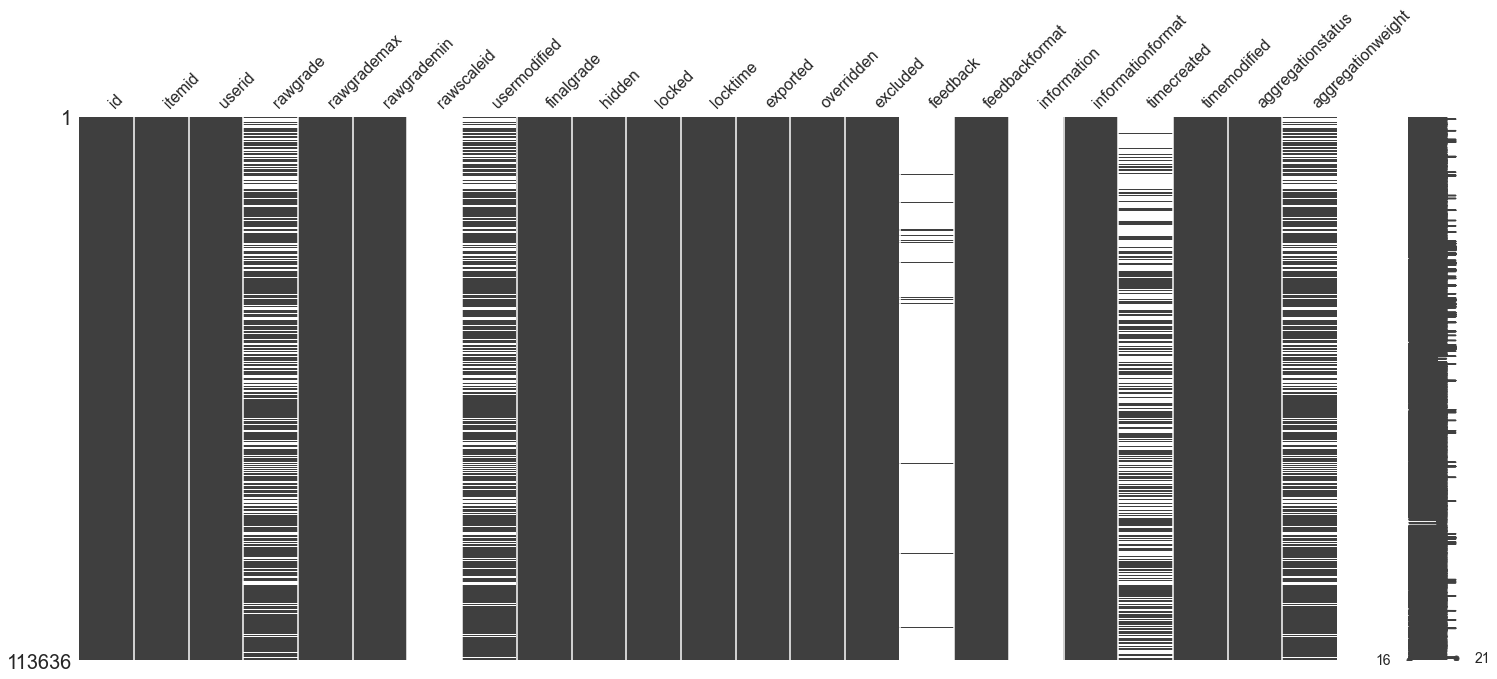

In [323]:
msno.matrix(grades)

## Grades scaled 1-100

In [324]:
grades_100 = grades[(grades.finalgrade>10)&(grades.finalgrade<=100)]
grades_100

id  itemid  userid  rawgrade  rawgrademax  rawgrademin  \
1          22563    1459    3058       NaN        100.0          0.0   
14           396     627    4686       NaN         24.0          0.0   
22           416     627    4759       NaN         24.0          0.0   
29           404     627    4720       NaN         24.0          0.0   
31           408     627    4729       NaN         24.0          0.0   
...          ...     ...     ...       ...          ...          ...   
1223288   467196   12599   23954       NaN         88.0          0.0   
1223290   612194   13812   18986      70.0        100.0          0.0   
1223292  1481964   13818   20184      17.0        100.0          0.0   
1223293  1481962   13812   20184      30.0        100.0          0.0   
1223294  1481963   13811   20184       NaN        200.0          0.0   

         rawscaleid  usermodified  finalgrade  hidden  ...  overridden  \
1               NaN           NaN   100.00000       0  ...           0   
14              NaN           NaN    24.00000       0  ...           0   
22              NaN           NaN    24.00000       0  ...           0   
29              NaN           NaN    24.00000       0  ...           0   
31              NaN           NaN    24.00000       0  ...           0   
...             ...           ...         ...     ...  ...         ...   
1223288         NaN           NaN    69.81818       0  ...           0   
1223290         NaN         926.0    70.00000       0  ...           0   
1223292         NaN         926.0    17.00000       0  ...           0   
1223293         NaN         926.0    30.00000       0  ...           0   
1223294         NaN           NaN    47.00000       0  ...           0   

         excluded                                           feedback  \
1               0                                                NaN   
14              0                                                NaN   
22              0                                                NaN   
29              0                                                NaN   
31              0                                                NaN   
...           ...                                                ...   
1223288         0                                                NaN   
1223290         0  <p>Please make sure the content related with t...   
1223292         0  <p>Konten baik dan memuaskan : (15), presentas...   
1223293         0  <p>Aktiviti yang dijalankan bersama kanak-kana...   
1223294         0                                                NaN   

         feedbackformat  information informationformat  timecreated  \
1                     0          NaN                 0          NaN   
14                    0          NaN                 0          NaN   
22                    0          NaN                 0          NaN   
29                    0          NaN                 0          NaN   
31                    0          NaN                 0          NaN   
...                 ...          ...               ...          ...   
1223288               0          NaN                 0          NaN   
1223290               1          NaN                 0          NaN   
1223292               1          NaN                 0          NaN   
1223293               1          NaN                 0          NaN   
1223294               0          NaN                 0          NaN   

         timemodified  aggregationstatus  aggregationweight  
1        1.538378e+09            unknown                NaN  
14       1.542362e+09            unknown                NaN  
22       1.542368e+09            unknown                NaN  
29       1.542337e+09            unknown                NaN  
31       1.542349e+09            unknown                NaN  
...               ...                ...                ...  
1223288  1.595311e+09            unknown                NaN  
1223290  1.605666e+09               used      

## Grades scaled 1-10

In [325]:
grades_10 = grades[grades.finalgrade<=10]
grades_10

id  itemid  userid  rawgrade  rawgrademax  rawgrademin  \
42        43376     665   10223       NaN        100.0          0.0   
104        7513      81    5360       NaN         10.0          0.0   
201        7512     124    5360   4.00000         10.0          0.0   
310        7517      81   16959       NaN         10.0          0.0   
361        7516     124   16959   7.00000         10.0          0.0   
...         ...     ...     ...       ...          ...          ...   
1223281  485983   14710   12470   0.54545          1.0          0.0   
1223283  485943   14710   12474   0.39394          1.0          0.0   
1223284  485975   14710   12475   0.78788          1.0          0.0   
1223285  485931   14710   12479   0.63636          1.0          0.0   
1223287  485955   14710   12529   0.33333          1.0          0.0   

         rawscaleid  usermodified  finalgrade  hidden  ...  overridden  \
42              NaN           NaN     6.70000       0  ...           0   
104             NaN           NaN     4.00000       0  ...           0   
201             NaN        5360.0     4.00000       0  ...           0   
310             NaN           NaN     7.00000       0  ...           0   
361             NaN       16959.0     7.00000       0  ...           0   
...             ...           ...         ...     ...  ...         ...   
1223281         NaN         559.0     0.54545       0  ...           0   
1223283         NaN         559.0     0.39394       0  ...           0   
1223284         NaN         559.0     0.78788       0  ...           0   
1223285         NaN         559.0     0.63636       0  ...           0   
1223287         NaN         559.0     0.33333       0  ...           0   

         excluded  feedback  feedbackformat  information informationformat  \
42              0       NaN               0          NaN                 0   
104             0       NaN               0          NaN                 0   
201             0       NaN               0          NaN                 0   
310             0       NaN               0          NaN                 0   
361             0       NaN               0          NaN                 0   
...           ...       ...             ...          ...               ...   
1223281         0       NaN               0          NaN                 0   
1223283         0       NaN               0          NaN                 0   
1223284         0       NaN               0          NaN                 0   
1223285         0       NaN               0          NaN                 0   
1223287         0       NaN               0          NaN                 0   

          timecreated  timemodified  aggregationstatus  aggregationweight  
42                NaN  1.545103e+09            unknown                NaN  
104               NaN  1.537421e+09            unknown                NaN  
201      1.537421e+09  1.537421e+09               used            1.00000  
310               NaN  1.537421e+09            unknown                NaN  
361      1.537421e+09  1.537421e+09               used            1.00000  
...               ...           ...                ...                ...  
1223281           NaN  1.595311e+09               used            0.01235  
1223283           NaN  1.595311e+09               used            0.02439  
1223284           NaN  1.595311e+09               used            0.01163  
1223285           NaN  1.595311e+09               used            0.01136  
1223287           NaN  1.595311e+09               used            0.01149  

[60557 rows x 23 columns]

## Grades scaled above 100

In [326]:
grades_100above = grades[grades.finalgrade>100]
grades_100above

id  itemid  userid  rawgrade  rawgrademax  rawgrademin  \
374          540     878    6133       NaN        500.0          0.0   
381          532     878    6132       NaN        500.0          0.0   
398          524     878   14939       NaN        500.0          0.0   
404          536     878    6135       NaN        500.0          0.0   
405          526     878   11440       NaN        500.0          0.0   
...          ...     ...     ...       ...          ...          ...   
1180767  1292924   12811    9903       NaN        230.0          0.0   
1182499   435181   12430    1986       NaN        250.0          0.0   
1182500   435185   12430    9920       NaN        250.0          0.0   
1190901   432502     696   13824       NaN        110.0          0.0   
1196503   430985   11360    6398       NaN        200.0          0.0   

         rawscaleid  usermodified  finalgrade  hidden  ...  overridden  \
374             NaN           NaN   364.00000       0  ...           0   
381             NaN           NaN   330.57143       0  ...           0   
398             NaN           NaN   321.00000       0  ...           0   
404             NaN           NaN   380.57143       0  ...           0   
405             NaN           NaN   355.57143       0  ...           0   
...             ...           ...         ...     ...  ...         ...   
1180767         NaN           NaN   114.66667       0  ...           0   
1182499         NaN           NaN   148.90000       0  ...           0   
1182500         NaN           NaN   147.50000       0  ...           0   
1190901         NaN           NaN   101.80769       0  ...           0   
1196503         NaN           NaN   191.66667       0  ...           0   

         excluded  feedback  feedbackformat  information informationformat  \
374             0       NaN               0          NaN                 0   
381             0       NaN               0          NaN                 0   
398             0       NaN               0          NaN                 0   
404             0       NaN               0          NaN                 0   
405             0       NaN               0          NaN                 0   
...           ...       ...             ...          ...               ...   
1180767         0       NaN               0          NaN                 0   
1182499         0       NaN               0          NaN                 0   
1182500         0       NaN               0          NaN                 0   
1190901         0       NaN               0          NaN                 0   
1196503         0       NaN               0          NaN                 0   

         timecreated  timemodified  aggregationstatus  aggregationweight  
374              NaN  1.547109e+09            unknown                NaN  
381              NaN  1.547109e+09            unknown                NaN  
398              NaN  1.547181e+09            unknown                NaN  
404              NaN  1.547109e+09            unknown                NaN  
405              NaN  1.547109e+09            unknown                NaN  
...              ...           ...                ...                ...  
1180767          NaN  1.560762e+09            unknown                NaN  
1182499          NaN  1.561432e+09            unknown                NaN  
1182500          NaN  1.561432e+09            unknown                NaN  
1190901          NaN  1.558941e+09            unknown                NaN  
1196503          NaN  1.559007e+09            unknown                NaN  

[3618 rows x 23 columns]

In [327]:
print(grades_100.shape)
print(grades_10.shape)
print(grades_100above.shape)
print(grades.shape)

print('')
print('rows in grades_100: ', grades_100.shape[0])
print('which is ', (grades_100.shape[0]/grades.shape[0])*100,' percent of the entire dataframe')

print('')
print('rows in grades_10: ', grades_10.shape[0])
print('which is ', (grades_10.shape[0]/grades.shape[0])*100,' percent of the entire dataframe')

print('')
print('rows in grades_100above: ', grades_100above.shape[0])
print('which is ', (grades_100above.shape[0]/grades.shape[0])*100,' percent of the entire dataframe')

(49461, 23)
(60557, 23)
(3618, 23)
(113636, 23)

rows in grades_100:  49461
which is  43.525819282621704  percent of the entire dataframe

rows in grades_10:  60557
which is  53.2903305290577  percent of the entire dataframe

rows in grades_100above:  3618
which is  3.1838501883206027  percent of the entire dataframe


## Grade_items

In [328]:
grade_items = pd.read_csv(f'{path}grade_items.csv')
grade_items

id  courseid  categoryid  \
0        136        57        38.0   
1       4985      2319         NaN   
2        181        72        41.0   
3         21        81         5.0   
4       2688      2064         NaN   
...      ...       ...         ...   
19500  23236        36         NaN   
19501  15622      3646      3475.0   
19502  16958      3646      3475.0   
19503  17534      3646      3475.0   
19504  13888      3646      3475.0   

                                                itemname itemtype itemmodule  \
0                                  Tutorial 2 Submission      mod     assign   
1                                                    NaN   course        NaN   
2      Submission of Assignment 1: Screen Shots - DEA...      mod     assign   
3                                             TUTORIAL 2      mod     assign   
4                                                    NaN   course        NaN   
...                                                  ...      ...        ...   
19500                                                NaN   course        NaN   
19501                                    Tutorial Week 3      mod     assign   
19502                            Tutorial Week 5 BID2008      mod     assign   
19503                    Tutorial Week 6 and 7 (BID2008)      mod     assign   
19504                       Upload Benchmarking exercise      mod     assign   

       iteminstance  itemnumber iteminfo idnumber  ...  sortorder  display  \
0              40.0         0.0      NaN      NaN  ...         34        0   
1            1941.0         NaN      NaN      NaN  ...          1        0   
2              82.0         0.0      NaN      NaN  ...          2        0   
3               8.0         0.0      NaN      NaN  ...          2        0   
4            1241.0         NaN      NaN      NaN  ...          1        0   
...             ...         ...      ...      ...  ...        ...      ...   
19500        4441.0         NaN      NaN      NaN  ...          1        0   
19501        8058.0         0.0      NaN      NaN  ...         12        0   
19502        8852.0         0.0      NaN      NaN  ...         13        0   
19503        9249.0         0.0      NaN      NaN  ...         14        0   
19504        7195.0         0.0      NaN      NaN  ...          5        0   

       decimals  hidden  locked  locktime  needsupdate  weightoverride  \
0           NaN       0       0         0            0               0   
1           NaN       0       0         0            1               0   
2           NaN       0       0         0            1               0   
3           NaN       1       0         0            0               0   
4           NaN       0       0         0            0               0   
...         ...     ...     ...       ...          ...             ...   
19500       NaN       0       0         0            1               0   
19501       NaN       1       0         0            0               0   
19502       NaN       1       0         0            0               0   
19503       NaN       1       0         0            0               0   
19504       NaN       1       0         0            0               0   

       timecreated  timemodified  
0       1536132254    1536132254  
1       1539739182    1539739182  
2       1536133724    1536133724  
3       1535424693    1537439536  
4       1538147356    1541058001  
...            ...           ...  
19500   1610678265    1610678265  
19501   1551838554    1615264921  
19502   1552951845    1615264934  
19503   1553481781    1615264950  
19504   1550732520    1615264973  

[19505 rows x 31 columns]

In [329]:
grade_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19505 entries, 0 to 19504
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                19505 non-null  int64  
 1   courseid          19505 non-null  int64  
 2   categoryid        15268 non-null  float64
 3   itemname          15257 non-null  object 
 4   itemtype          19505 non-null  object 
 5   itemmodule        15240 non-null  object 
 6   iteminstance      19477 non-null  float64
 7   itemnumber        15268 non-null  float64
 8   iteminfo          1 non-null      object 
 9   idnumber          89 non-null     object 
 10  calculation       0 non-null      float64
 11  gradetype         19505 non-null  int64  
 12  grademax          19505 non-null  float64
 13  grademin          19505 non-null  float64
 14  scaleid           30 non-null     float64
 15  outcomeid         3 non-null      float64
 16  gradepass         19505 non-null  float6

<AxesSubplot:>

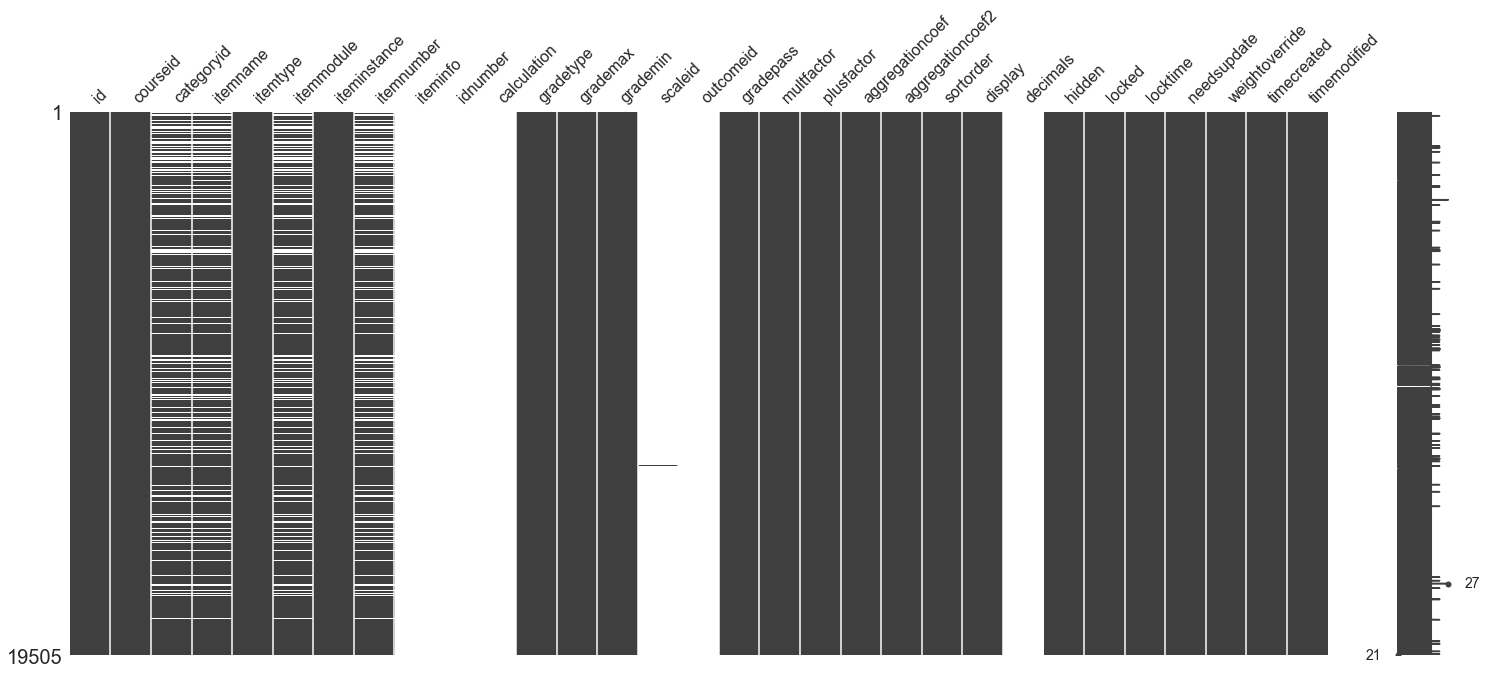

In [330]:
msno.matrix(grade_items)

In [331]:
grade_items.describe()

id      courseid    categoryid  iteminstance    itemnumber  \
count  19505.000000  19505.000000  15268.000000  19477.000000  15268.000000   
mean   12021.722738   2676.035940   2071.678019   4619.904246      0.203825   
std     6681.890900   1494.821618   1315.865265   3994.839003     14.030723   
min       14.000000      1.000000      4.000000      1.000000      0.000000   
25%     6276.000000   1519.000000    768.750000   1123.000000      0.000000   
50%    12239.000000   2566.000000   2293.000000   3342.000000      0.000000   
75%    17848.000000   3990.000000   3148.000000   7895.000000      0.000000   
max    23236.000000   5287.000000   4437.000000  13184.000000   1002.000000   

       calculation     gradetype      grademax      grademin    scaleid  ...  \
count          0.0  19505.000000  19505.000000  19505.000000  30.000000  ...   
mean           NaN      1.014407    113.167983      0.001538   2.766667  ...   
std            NaN      0.213009    189.139002      0.039189   1.906130  ...   
min            NaN      0.000000      0.000000      0.000000   1.000000  ...   
25%            NaN      1.000000    100.000000      0.000000   2.000000  ...   
50%            NaN      1.000000    100.000000      0.000000   2.000000  ...   
75%            NaN      1.000000    100.000000      0.000000   3.750000  ...   
max            NaN      3.000000   6920.000000      1.000000   8.000000  ...   

          sortorder       display  decimals        hidden   locked  locktime  \
count  19505.000000  19505.000000       2.0  1.950500e+04  19505.0   19505.0   
mean      16.865727      0.000051       1.0  6.909326e+07      0.0       0.0   
std       52.820854      0.007160       0.0  3.196346e+08      0.0       0.0   
min        1.000000      0.000000       1.0  0.000000e+00      0.0       0.0   
25%        2.000000      0.000000       1.0  0.000000e+00      0.0       0.0   
50%        4.000000      0.000000       1.0  0.000000e+00      0.0       0.0   
75%       10.000000      0.000000       1.0  0.000000e+00      0.0       0.0   
max      558.000000      1.000000       1.0  1.699505e+09      0.0       0.0   

        needsupdate  weightoverride   timecreated  timemodified  
count  19505.000000    19505.000000  1.950500e+04  1.950500e+04  
mean       0.041835        0.001999  1.547092e+09  1.551417e+09  
std        0.200218        0.044672  1.587800e+07  1.411976e+07  
min        0.000000        0.000000  1.283737e+09  1.318001e+09  
25%        0.000000        0.000000  1.541316e+09  1.545359e+09  
50%        0.000000        0.000000  1.550325e+09  1.553015e+09  
75%        0.000000        0.000000  1.553740e+09  1.558378e+09  
max        1.000000        1.000000  1.664130e+09  1.730452e+09  

[8 rows x 26 columns]

In [332]:
grade_items.id.nunique()

19505

In [333]:
grade_items.sort_values(by='id', inplace=True)
grade_items

id  courseid  categoryid                itemname itemtype  \
9         14         2         NaN                     NaN   course   
10        15         2         4.0               TEST MARK      mod   
11755     19        81         NaN                     NaN   course   
3         21        81         5.0              TUTORIAL 2      mod   
18        22        81         5.0              TUTORIAL 3      mod   
...      ...       ...         ...                     ...      ...   
19485  23232      4624      3717.0                    quiz      mod   
19488  23233      4624      3717.0                    quiz      mod   
19487  23234      4624      3717.0  bengkel 1 (submission)      mod   
19486  23235      4624      3717.0  bengkel 1 (assessment)      mod   
19500  23236        36         NaN                     NaN   course   

      itemmodule  iteminstance  itemnumber iteminfo idnumber  ...  sortorder  \
9            NaN           4.0         NaN      NaN      NaN  ...          1   
10          quiz           2.0         0.0      NaN      NaN  ...          2   
11755        NaN           5.0         NaN      NaN      NaN  ...          1   
3         assign           8.0         0.0      NaN      NaN  ...          2   
18        assign           9.0         0.0      NaN      NaN  ...          3   
...          ...           ...         ...      ...      ...  ...        ...   
19485       quiz        2496.0         0.0      NaN      NaN  ...          2   
19488       quiz        2497.0         0.0      NaN      NaN  ...          3   
19487   workshop         137.0         0.0      NaN      NaN  ...          4   
19486   workshop         137.0         1.0      NaN      NaN  ...          5   
19500        NaN        4441.0         NaN      NaN      NaN  ...          1   

       display  decimals  hidden  locked  locktime  needsupdate  \
9            0       NaN       0       0         0            0   
10           0       NaN       0       0         0            0   
11755        0       NaN       0       0         0            1   
3            0       NaN       1       0         0            0   
18           0       NaN       1       0         0            0   
...        ...       ...     ...     ...       ...          ...   
19485        0       NaN       0       0         0            0   
19488        0       NaN       0       0         0            0   
19487        0       NaN       0       0         0            0   
19486        0       NaN       0       0         0            0   
19500        0       NaN       0       0         0            1   

       weightoverride  timecreated  timemodified  
9                   0   1527124806    1527124865  
10                  0   1527124865    1527124865  
11755               0   1505813081    1554704459  
3                   0   1535424693    1537439536  
18                  0   1535424693    1538725328  
...               ...          ...           ...  
19485               0   1577790063    1577790405  
19488               0   1577790076    1577790405  
19487               0   1577790405    1577790405  
19486               0   1577790405    1577790405  
19500               0   1610678265    1610678265  

[19505 rows x 31 columns]

In [334]:
grade_items[grade_items.itemname.notna()]

id  courseid  categoryid                itemname itemtype  \
10        15         2         4.0               TEST MARK      mod   
3         21        81         5.0              TUTORIAL 2      mod   
18        22        81         5.0              TUTORIAL 3      mod   
21        23        81         5.0           GROUP PROJECT      mod   
8         28        81         5.0  Data Design_Assignment      mod   
...      ...       ...         ...                     ...      ...   
19482  23231      1691      2023.0                  Quiz 1      mod   
19485  23232      4624      3717.0                    quiz      mod   
19488  23233      4624      3717.0                    quiz      mod   
19487  23234      4624      3717.0  bengkel 1 (submission)      mod   
19486  23235      4624      3717.0  bengkel 1 (assessment)      mod   

      itemmodule  iteminstance  itemnumber iteminfo idnumber  ...  sortorder  \
10          quiz           2.0         0.0      NaN      NaN  ...          2   
3         assign           8.0         0.0      NaN      NaN  ...          2   
18        assign           9.0         0.0      NaN      NaN  ...          3   
21        assign          10.0         0.0      NaN      NaN  ...          4   
8         assign          15.0         0.0      NaN      NaN  ...         10   
...          ...           ...         ...      ...      ...  ...        ...   
19482       quiz        2495.0         0.0      NaN      NaN  ...          3   
19485       quiz        2496.0         0.0      NaN      NaN  ...          2   
19488       quiz        2497.0         0.0      NaN      NaN  ...          3   
19487   workshop         137.0         0.0      NaN      NaN  ...          4   
19486   workshop         137.0         1.0      NaN      NaN  ...          5   

       display  decimals  hidden  locked  locktime  needsupdate  \
10           0       NaN       0       0         0            0   
3            0       NaN       1       0         0            0   
18           0       NaN       1       0         0            0   
21           0       NaN       1       0         0            0   
8            0       NaN       0       0         0            0   
...        ...       ...     ...     ...       ...          ...   
19482        0       NaN       0       0         0            0   
19485        0       NaN       0       0         0            0   
19488        0       NaN       0       0         0            0   
19487        0       NaN       0       0         0            0   
19486        0       NaN       0       0         0            0   

       weightoverride  timecreated  timemodified  
10                  0   1527124865    1527124865  
3                   0   1535424693    1537439536  
18                  0   1535424693    1538725328  
21                  0   1535424693    1539928477  
8                   0   1535424693    1554704459  
...               ...          ...           ...  
19482               0   1577789810    1577791265  
19485               0   1577790063    1577790405  
19488               0   1577790076    1577790405  
19487               0   1577790405    1577790405  
19486               0   1577790405    1577790405  

[15257 rows x 31 columns]

Notice that when the itemname is notNa, all the items are mod,quiz,assignment,etc, but not courses.

In [335]:
# number of unique item types
print(grade_items.itemtype.unique())
print()
# number of unique item modules
print(grade_items.itemmodule.unique())
print()
# info on max grades
print(grade_items.grademax.nunique())
print()
print(grade_items.courseid.nunique())

['course' 'mod' 'category' 'manual']

[nan 'quiz' 'assign' 'lti' 'assignment' 'turnitintool' 'attendance'
 'turnitintooltwo' 'lesson' 'workshop' 'hvp' 'questionnaire' 'forum'
 'glossary' 'scorm' 'data']

218

4218


# Joining Grade, Grade_items, course, course category

First inspect all the dataframes

In [336]:
grades.head()

id  itemid  userid  rawgrade  rawgrademax  rawgrademin  rawscaleid  \
1   22563    1459    3058       NaN        100.0          0.0         NaN   
14    396     627    4686       NaN         24.0          0.0         NaN   
22    416     627    4759       NaN         24.0          0.0         NaN   
29    404     627    4720       NaN         24.0          0.0         NaN   
31    408     627    4729       NaN         24.0          0.0         NaN   

    usermodified  finalgrade  hidden  ...  overridden  excluded  feedback  \
1            NaN       100.0       0  ...           0         0       NaN   
14           NaN        24.0       0  ...           0         0       NaN   
22           NaN        24.0       0  ...           0         0       NaN   
29           NaN        24.0       0  ...           0         0       NaN   
31           NaN        24.0       0  ...           0         0       NaN   

    feedbackformat  information informationformat  timecreated  timemodified  \
1                0          NaN                 0          NaN  1.538378e+09   
14               0          NaN                 0          NaN  1.542362e+09   
22               0          NaN                 0          NaN  1.542368e+09   
29               0          NaN                 0          NaN  1.542337e+09   
31               0          NaN                 0          NaN  1.542349e+09   

    aggregationstatus  aggregationweight  
1             unknown                NaN  
14            unknown                NaN  
22            unknown                NaN  
29            unknown                NaN  
31            unknown                NaN  

[5 rows x 23 columns]

In [337]:
grade_items.head()

id  courseid  categoryid    itemname itemtype itemmodule  iteminstance  \
9      14         2         NaN         NaN   course        NaN           4.0   
10     15         2         4.0   TEST MARK      mod       quiz           2.0   
11755  19        81         NaN         NaN   course        NaN           5.0   
3      21        81         5.0  TUTORIAL 2      mod     assign           8.0   
18     22        81         5.0  TUTORIAL 3      mod     assign           9.0   

       itemnumber iteminfo idnumber  ...  sortorder  display  decimals  \
9             NaN      NaN      NaN  ...          1        0       NaN   
10            0.0      NaN      NaN  ...          2        0       NaN   
11755         NaN      NaN      NaN  ...          1        0       NaN   
3             0.0      NaN      NaN  ...          2        0       NaN   
18            0.0      NaN      NaN  ...          3        0       NaN   

       hidden  locked  locktime  needsupdate  weightoverride  timecreated  \
9           0       0         0            0               0   1527124806   
10          0       0         0            0               0   1527124865   
11755       0       0         0            1               0   1505813081   
3           1       0         0            0               0   1535424693   
18          1       0         0            0               0   1535424693   

       timemodified  
9        1527124865  
10       1527124865  
11755    1554704459  
3        1537439536  
18       1538725328  

[5 rows x 31 columns]

In [338]:
print(grades.itemid.nunique())

print(grade_items.id.nunique())

2486
19505


Therefore, the itemid in the grades df and the id in grade_items might not be the same. Or they're indeed the same thing, but most of the items are not graded.

In [339]:
course.head()

id  category  sortorder  \
0  5104        40      30001   
1  4298        18     390243   
2  5114        18     390005   
3  2440         3      50026   
4  3237         9     110051   

                                            fullname shortname idnumber  \
0                          Enhancing Research Impact       ERI      ERI   
1  SIJ3004 Biokimia Klinikal Dan Fisiologi (Clini...   SIJ3004  SIJ3004   
2  CNU046 Korean Listening And Speaking 1 (Korean...    CNU046   CNU046   
3       GKN1001 Khidmat Komuniti (Community Service)   GKN1001  GKN1001   
4  EIE3007/ESEE3104 Rekabentuk Ujikaji (Experimen...   EIE3007  EIE3007   

                                       summary  summaryformat  format  \
0                                          NaN              1  topics   
1    Session 2018/2019 Semester 2<br>(Group 1)              1  topics   
2    Session 2018/2019 Semester 2<br>(Group 1)              1  topics   
3  Session 2018/2019 Semester 2<br>(Group 1,2)              1  topics   
4                     <p>Session 2018/2019</p>              1  topics   

   showgrades  ...  defaultgroupingid  lang  calendartype  theme  timecreated  \
0           1  ...                  0   NaN           NaN    NaN   1555295477   
1           1  ...                  0   NaN           NaN    NaN            0   
2           1  ...                  0   NaN           NaN    NaN            0   
3           1  ...                  0   NaN           NaN    NaN            0   
4           1  ...                  0   NaN           NaN    NaN   1548403431   

   timemodified  requested  enablecompletion  completionnotify    cacherev  
0    1555295477          0                 1                 0  1555301229  
1             0          0                 0                 0  1560508270  
2             0          0                 0                 0  1555634911  
3             0          0                 0                 0  1540439630  
4    1548403431          0                 1                 0  1548405378  

[5 rows x 31 columns]

In [340]:
course_category.head()

id                                               name idnumber  \
0  19  Faculty of Computer Science & Information Tech...        W   
1   7                                    Cultural Centre        R   
2  12               Faculty of Languages and Linguistics        T   
3  40                                            Epigeum      NaN   
4  11                             Faculty of Engineering        K   

                                         description  descriptionformat  \
0  <p>Faculty of Computer Science &amp; Informati...                  1   
1                             <p>Cultural Centre</p>                  1   
2        <p>Faculty of Languages and Linguistics</p>                  1   
3                                                NaN                  1   
4                      <p>Faculty of Engineering</p>                  1   

   parent  sortorder  coursecount  visible  visibleold  timemodified  depth  \
0       0     400000          195        1           1    1534731526      1   
1       0      90000          156        1           1    1534731833      1   
2       0     130000          402        1           1    1534731132      1   
3       1      30000            1        0           1    1555295432      2   
4       0     120000          442        1           1    1534731102      1   

    path  theme  
0    /19    NaN  
1     /7    NaN  
2    /12    NaN  
3  /1/40    NaN  
4    /11    NaN

Now join the grade and grade items dataframes. We'll join the course and course_category dataframes afterwards

## Merging the grade and gradeitems df's first

In [341]:
grade_items.rename(columns={'id':'itemid'},inplace=True)

In [342]:
grade_items

itemid  courseid  categoryid                itemname itemtype  \
9          14         2         NaN                     NaN   course   
10         15         2         4.0               TEST MARK      mod   
11755      19        81         NaN                     NaN   course   
3          21        81         5.0              TUTORIAL 2      mod   
18         22        81         5.0              TUTORIAL 3      mod   
...       ...       ...         ...                     ...      ...   
19485   23232      4624      3717.0                    quiz      mod   
19488   23233      4624      3717.0                    quiz      mod   
19487   23234      4624      3717.0  bengkel 1 (submission)      mod   
19486   23235      4624      3717.0  bengkel 1 (assessment)      mod   
19500   23236        36         NaN                     NaN   course   

      itemmodule  iteminstance  itemnumber iteminfo idnumber  ...  sortorder  \
9            NaN           4.0         NaN      NaN      NaN  ...          1   
10          quiz           2.0         0.0      NaN      NaN  ...          2   
11755        NaN           5.0         NaN      NaN      NaN  ...          1   
3         assign           8.0         0.0      NaN      NaN  ...          2   
18        assign           9.0         0.0      NaN      NaN  ...          3   
...          ...           ...         ...      ...      ...  ...        ...   
19485       quiz        2496.0         0.0      NaN      NaN  ...          2   
19488       quiz        2497.0         0.0      NaN      NaN  ...          3   
19487   workshop         137.0         0.0      NaN      NaN  ...          4   
19486   workshop         137.0         1.0      NaN      NaN  ...          5   
19500        NaN        4441.0         NaN      NaN      NaN  ...          1   

       display  decimals  hidden  locked  locktime  needsupdate  \
9            0       NaN       0       0         0            0   
10           0       NaN       0       0         0            0   
11755        0       NaN       0       0         0            1   
3            0       NaN       1       0         0            0   
18           0       NaN       1       0         0            0   
...        ...       ...     ...     ...       ...          ...   
19485        0       NaN       0       0         0            0   
19488        0       NaN       0       0         0            0   
19487        0       NaN       0       0         0            0   
19486        0       NaN       0       0         0            0   
19500        0       NaN       0       0         0            1   

       weightoverride  timecreated  timemodified  
9                   0   1527124806    1527124865  
10                  0   1527124865    1527124865  
11755               0   1505813081    1554704459  
3                   0   1535424693    1537439536  
18                  0   1535424693    1538725328  
...               ...          ...           ...  
19485               0   1577790063    1577790405  
19488               0   1577790076    1577790405  
19487               0   1577790405    1577790405  
19486               0   1577790405    1577790405  
19500               0   1610678265    1610678265  

[19505 rows x 31 columns]

We'll join on hte itemid column because that exists in both dataframes. And we'll do an inner join because we need all the data to be graded to be meaningfull

In [343]:
grades_consolidated = grades.merge(grade_items, on='itemid', how='inner')

In [344]:
grades_consolidated

id  itemid  userid  rawgrade  rawgrademax  rawgrademin  \
0         22563    1459    3058       NaN        100.0          0.0   
1         24184    1459    3045       NaN        100.0          0.0   
2         24207    1459    3053       NaN        100.0          0.0   
3         22859    1459    3063       NaN        100.0          0.0   
4         22968    1459    3049       NaN        100.0          0.0   
...         ...     ...     ...       ...          ...          ...   
113631  1457453   22920   18416      61.0         80.0          0.0   
113632   980057   14756   11065      10.0        100.0          0.0   
113633   612194   13812   18986      70.0        100.0          0.0   
113634  1481962   13812   20184      30.0        100.0          0.0   
113635  1481964   13818   20184      17.0        100.0          0.0   

        rawscaleid  usermodified  finalgrade  hidden_x  ...  sortorder  \
0              NaN           NaN       100.0         0  ...          1   
1              NaN           NaN       100.0         0  ...          1   
2              NaN           NaN         0.0         0  ...          1   
3              NaN           NaN       100.0         0  ...          1   
4              NaN           NaN       100.0         0  ...          1   
...            ...           ...         ...       ...  ...        ...   
113631         NaN       18416.0        61.0         0  ...          3   
113632         NaN         926.0        10.0         0  ...          2   
113633         NaN         926.0        70.0         0  ...          2   
113634         NaN         926.0        30.0         0  ...          2   
113635         NaN         926.0        17.0         0  ...          3   

        display  decimals    hidden_y  locked_y locktime_y  needsupdate  \
0             0       NaN           0         0          0            0   
1             0       NaN           0         0          0            0   
2             0       NaN           0         0          0            0   
3             0       NaN           0         0          0            0   
4             0       NaN           0         0          0            0   
...         ...       ...         ...       ...        ...          ...   
113631        0       NaN  1561043880         0          0            0   
113632        0       NaN           0         0          0            0   
113633        0       NaN           0         0          0            0   
113634        0       NaN           0         0          0            0   
113635        0       NaN           0         0          0            0   

        weightoverride  timecreated_y  timemodified_y  
0                    0     1536844021      1545027366  
1                    0     1536844021      1545027366  
2                    0     1536844021      1545027366  
3                    0     1536844021      1545027366  
4                    0     1536844021      1545027366  
...                ...            ...             ...  
113631               0     1560179988      1560179988  
113632               0     1551407780      1551407891  
113633               0     1550718954      1558282837  
113634               0     1550718954      1558282837  
113635               0     1550720513      1558282837  

[113636 rows x 53 columns]

Checking if the number of unique itemid's of this merged dataframe matches that of the grades dataframe

In [345]:
print(grades_consolidated.itemid.nunique())

print(grades.itemid.nunique())


2486
2486


Therefore it matches! Now we need to remove the irrelevant columns or conversely, include only the relevant columns

In [346]:
grades_consolidated = grades_consolidated[['id','userid','courseid','itemid','itemname','itemtype','itemmodule','scaleid','grademax','finalgrade']]

In [347]:
grades_consolidated

id  userid  courseid  itemid              itemname itemtype  \
0         22563    3058        60    1459                   NaN   course   
1         24184    3045        60    1459                   NaN   course   
2         24207    3053        60    1459                   NaN   course   
3         22859    3063        60    1459                   NaN   course   
4         22968    3049        60    1459                   NaN   course   
...         ...     ...       ...     ...                   ...      ...   
113631  1457453   18416      3689   22920  FINAL RESEARCH ESSAY      mod   
113632   980057   11065      4179   14756          Assignment 1      mod   
113633   612194   18986      4195   13812          Assignment 1      mod   
113634  1481962   20184      4195   13812          Assignment 1      mod   
113635  1481964   20184      4195   13818          Assignment 2      mod   

             itemmodule  scaleid  grademax  finalgrade  
0                   NaN      NaN    1400.0       100.0  
1                   NaN      NaN    1400.0       100.0  
2                   NaN      NaN    1400.0         0.0  
3                   NaN      NaN    1400.0       100.0  
4                   NaN      NaN    1400.0       100.0  
...                 ...      ...       ...         ...  
113631  turnitintooltwo      NaN      80.0        61.0  
113632           assign      NaN     100.0        10.0  
113633           assign      NaN     100.0        70.0  
113634           assign      NaN     100.0        30.0  
113635           assign      NaN     100.0        17.0  

[113636 rows x 10 columns]

In [348]:
#grades_consolidated.set_index('id',inplace=True)

In [349]:
#grades_consolidated

<AxesSubplot:>

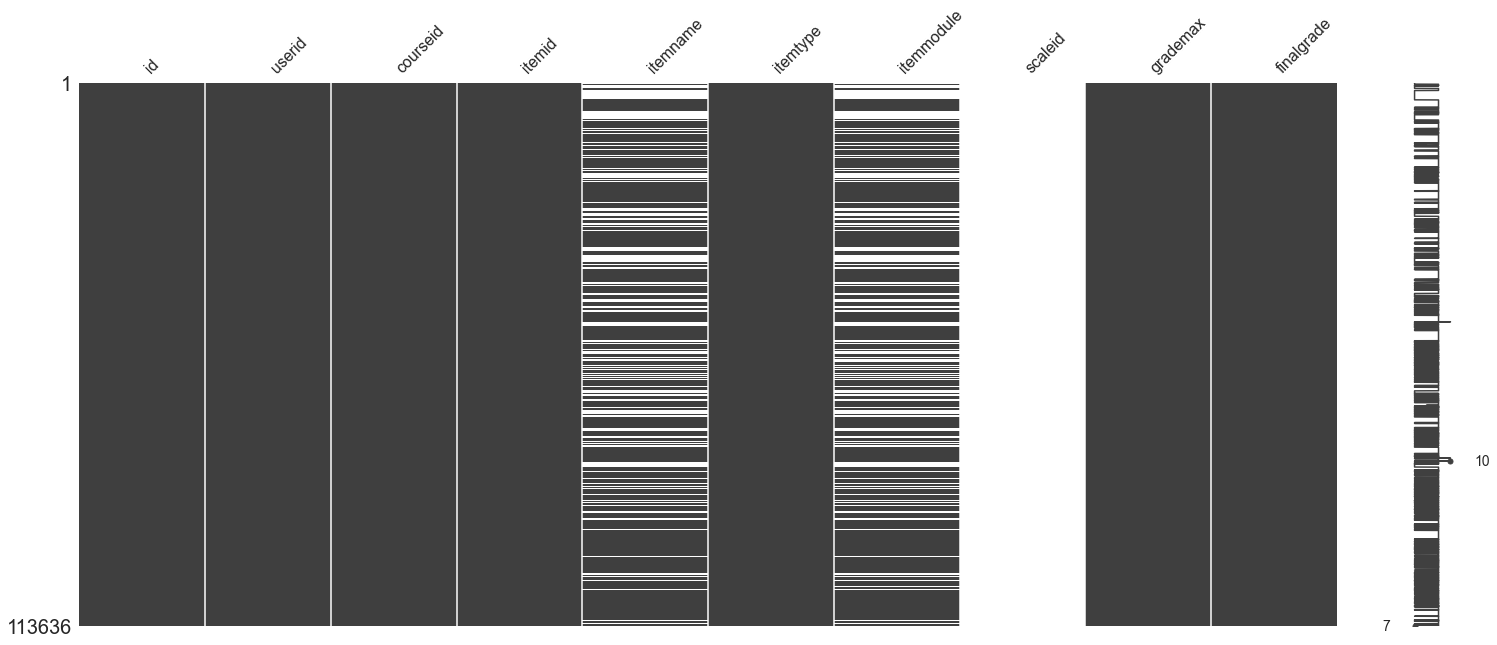

In [350]:
msno.matrix(grades_consolidated)

In [351]:
grades_consolidated.describe()

id         userid       courseid         itemid   scaleid  \
count  1.136360e+05  113636.000000  113636.000000  113636.000000  7.000000   
mean   6.398131e+05   10913.053073    2523.252658   11284.128348  1.571429   
std    3.933223e+05    6112.752710    1262.720576    6851.688897  0.534522   
min    2.620000e+02      64.000000      10.000000      29.000000  1.000000   
25%    4.309148e+05    5535.000000    1555.000000    5322.000000  1.000000   
50%    5.448105e+05   10451.000000    2414.000000   11921.000000  2.000000   
75%    9.563778e+05   14722.000000    3318.000000   16897.000000  2.000000   
max    1.481964e+06   28217.000000    5182.000000   23211.000000  2.000000   

           grademax     finalgrade  
count  113636.00000  113636.000000  
mean      204.37977      36.303812  
std       652.25368      63.021061  
min         0.00000       0.000000  
25%        10.00000       8.500000  
50%        20.00000      10.000000  
75%       100.00000      63.514250  
max      6920.00000    2550.000000

In [352]:
# grades_consolidated.to_csv(f'{ppath}grades_consolidated.csv')

It's weird that the maximum grademax is 6920. What does this column actually refer to? Judging by it's scale, it probably isn't referring to the maximum achievable mark in a course.

In [353]:
grades_consolidated.loc[grades_consolidated.grademax==grades_consolidated.grademax.max()]

id  userid  courseid  itemid itemname itemtype itemmodule  scaleid  \
640     8049    3373       131     384      NaN   course        NaN      NaN   
641     8051    3365       131     384      NaN   course        NaN      NaN   
642     8055    3597       131     384      NaN   course        NaN      NaN   
643     8861    3583       131     384      NaN   course        NaN      NaN   
644     3629    3608       131     384      NaN   course        NaN      NaN   
...      ...     ...       ...     ...      ...      ...        ...      ...   
1075    4623    7400       131     384      NaN   course        NaN      NaN   
1076   10155   16255       131     384      NaN   course        NaN      NaN   
1077  357306   16322       131     384      NaN   course        NaN      NaN   
1078  357630   18778       131     384      NaN   course        NaN      NaN   
1079  358097   16297       131     384      NaN   course        NaN      NaN   

      grademax  finalgrade  
640     6920.0        19.0  
641     6920.0         7.0  
642     6920.0         5.2  
643     6920.0        19.0  
644     6920.0        14.0  
...        ...         ...  
1075    6920.0        20.0  
1076    6920.0        18.8  
1077    6920.0        10.0  
1078    6920.0         9.0  
1079    6920.0        10.0  

[440 rows x 10 columns]

## Merging the course and course_categories df's

In [354]:
course.head()

id  category  sortorder  \
0  5104        40      30001   
1  4298        18     390243   
2  5114        18     390005   
3  2440         3      50026   
4  3237         9     110051   

                                            fullname shortname idnumber  \
0                          Enhancing Research Impact       ERI      ERI   
1  SIJ3004 Biokimia Klinikal Dan Fisiologi (Clini...   SIJ3004  SIJ3004   
2  CNU046 Korean Listening And Speaking 1 (Korean...    CNU046   CNU046   
3       GKN1001 Khidmat Komuniti (Community Service)   GKN1001  GKN1001   
4  EIE3007/ESEE3104 Rekabentuk Ujikaji (Experimen...   EIE3007  EIE3007   

                                       summary  summaryformat  format  \
0                                          NaN              1  topics   
1    Session 2018/2019 Semester 2<br>(Group 1)              1  topics   
2    Session 2018/2019 Semester 2<br>(Group 1)              1  topics   
3  Session 2018/2019 Semester 2<br>(Group 1,2)              1  topics   
4                     <p>Session 2018/2019</p>              1  topics   

   showgrades  ...  defaultgroupingid  lang  calendartype  theme  timecreated  \
0           1  ...                  0   NaN           NaN    NaN   1555295477   
1           1  ...                  0   NaN           NaN    NaN            0   
2           1  ...                  0   NaN           NaN    NaN            0   
3           1  ...                  0   NaN           NaN    NaN            0   
4           1  ...                  0   NaN           NaN    NaN   1548403431   

   timemodified  requested  enablecompletion  completionnotify    cacherev  
0    1555295477          0                 1                 0  1555301229  
1             0          0                 0                 0  1560508270  
2             0          0                 0                 0  1555634911  
3             0          0                 0                 0  1540439630  
4    1548403431          0                 1                 0  1548405378  

[5 rows x 31 columns]

In [355]:
course_category.head()

id                                               name idnumber  \
0  19  Faculty of Computer Science & Information Tech...        W   
1   7                                    Cultural Centre        R   
2  12               Faculty of Languages and Linguistics        T   
3  40                                            Epigeum      NaN   
4  11                             Faculty of Engineering        K   

                                         description  descriptionformat  \
0  <p>Faculty of Computer Science &amp; Informati...                  1   
1                             <p>Cultural Centre</p>                  1   
2        <p>Faculty of Languages and Linguistics</p>                  1   
3                                                NaN                  1   
4                      <p>Faculty of Engineering</p>                  1   

   parent  sortorder  coursecount  visible  visibleold  timemodified  depth  \
0       0     400000          195        1           1    1534731526      1   
1       0      90000          156        1           1    1534731833      1   
2       0     130000          402        1           1    1534731132      1   
3       1      30000            1        0           1    1555295432      2   
4       0     120000          442        1           1    1534731102      1   

    path  theme  
0    /19    NaN  
1     /7    NaN  
2    /12    NaN  
3  /1/40    NaN  
4    /11    NaN

We'll join on the id column of the category dataframe. First we'll have to change the names of the columns so that they match.

In [356]:
course_category.index

RangeIndex(start=0, stop=45, step=1)

Currently the id columns is the index and so we won't be able to rename it.

In [357]:
course_category.reset_index(inplace=True)

In [358]:
course_category.rename(columns={'id':'category'},inplace=True)

In [359]:
course_category

index  category                                               name  \
0       0        19  Faculty of Computer Science & Information Tech...   
1       1         7                                    Cultural Centre   
2       2        12               Faculty of Languages and Linguistics   
3       3        40                                            Epigeum   
4       4        11                             Faculty of Engineering   
5       5        13                                     Faculty of Law   
6       6         4                Faculty of Arts and Social Sciences   
7       7         6                Faculty of Business and Accountancy   
8       8        26                           Undergraduate Programmes   
9       9        21                      Foundation of Islamic Studies   
10     10        22                                               SKET   
11     11        23                           Academy of Malay Studies   
12     12        24                Institute of Educational Leadership   
13     13        45                                        S2migration   
14     14        25                                               ADEC   
15     15        10                               Faculty of Education   
16     16        14                                Faculty of Medicine   
17     17        18                                 Faculty of Science   
18     18         2                      Foundation Studies in Science   
19     19        27                            Postgraduate Programmes   
20     20         1                                      Miscellaneous   
21     21         9              Faculty of Economics & Administration   
22     22         3                                         University   
23     23         5                        Faculty of Built Enviroment   
24     24        20                         Academy of Islamic Studies   
25     25        28       Bachelor of Medicine and Bachelor of Surgery   
26     26         8                               Faculty of Dentistry   
27     27        39                        Faculty Development Program   
28     28        15                                   Graduate Studies   
29     29        16                                             INPUMA   
30     30        17                                       Sport Centre   
31     31        31                                    UMMP Curriculum   
32     32        38                     BLOCK 1 - Language in Medicine   
33     33        35                                   UMMP Assessment    
34     34        33                       UMMP Course Forms - Proforma   
35     35        34                               UMMP - POC & Archive   
36     36        46                                        s1Migration   
37     37        30      University of Malaya Medical Programme (UMMP)   
38     38        41  MIA 3001: PRACTICE OF CLINICAL MEDICINE 1; STA...   
39     39        32                                    UMMP Evaluation   
40     40        42  MIA 5001 : PRACTICE OF CLINICAL MEDICINE 3; ST...   
41     41        43  MIA 4001 : PRACTICE OF CLINICAL MEDICINE 2; ST...   
42     42        36  MIA1001: MEDICAL SCIENCES 1 ; STAGE 1 [ BLOCK ...   
43     43        37  MIA 2001: MEDICAL SCIENCES 2; STAGE 2 [ BLOCK ...   
44     44        44                                        S1migration   

       idnumber                                        description  \
0             W  <p>Faculty of Computer Science &amp; Informati...   
1             R                             <p>Cultural Centre</p>   
2             T        <p>Faculty of Languages and Linguistics</p>   
3           NaN                                                NaN   
4             K                      <p>Faculty of Engineering</p>   
5             L                              <p>Faculty of Law</p>   
6             A         <p>Faculty of Arts and Social Sciences</p>   
7             C         <p>Faculty of B

In [360]:
course_info= course.merge(course_category, on='category',how='inner')

In [361]:
# course_info.head()
course_info

id  category  sortorder_x  \
0     5104        40        30001   
1     4298        18       390243   
2     5114        18       390005   
3     4277        18       390264   
4     4358        18       390183   
...    ...       ...          ...   
5175  4868        27       340002   
5176  2823        24       450004   
5177  2826        24       450001   
5178  2825        24       450002   
5179  2824        24       450003   

                                               fullname shortname idnumber_x  \
0                             Enhancing Research Impact       ERI        ERI   
1     SIJ3004 Biokimia Klinikal Dan Fisiologi (Clini...   SIJ3004    SIJ3004   
2     CNU046 Korean Listening And Speaking 1 (Korean...    CNU046     CNU046   
3     SIP1004 Trend Dan Isu-Isu Dalam Pendidikan Kim...   SIP1004    SIP1004   
4     SIO2005 Teknik-Teknik Analisis Dalam Bioteknol...   SIO2005    SIO2005   
...                                                 ...       ...        ...   
5175  MQB7038 Perubatan Pekerjaan Klinikal (Clinical...   MQB7038    MQB7038   
5176  YXGB6101 Teori/model Kontemporari Dalam Kepimp...  YXGB6101   YXGB6101   
5177  YXGB6110 Penyelidikan Kualitatif (Qualitative ...  YXGB6110   YXGB6110   
5178  YXGB6104 Rekabentuk Penyelidikan (Research Des...  YXGB6104   YXGB6104   
5179  YXGB6111 Kaedah Penyelidikan Kuantitatif (Quan...  YXGB6111   YXGB6111   

                                        summary  summaryformat        format  \
0                                           NaN              1        topics   
1     Session 2018/2019 Semester 2<br>(Group 1)              1        topics   
2     Session 2018/2019 Semester 2<br>(Group 1)              1        topics   
3     Session 2018/2019 Semester 2<br>(Group 1)              1        topics   
4     Session 2018/2019 Semester 2<br>(Group 1)              1        topics   
...                                         ...            ...           ...   
5175  Session 2018/2019 Semester 2<br>(Group 1)              1  flexsections   
5176  Session 2018/2019 Semester 1<br>(Group 1)              1        topics   
5177  Session 2018/2019 Semester 1<br>(Group 1)              1        topics   
5178               Session 2018/2019 Semester 1              1        topics   
5179               Session 2018/2019 Semester 1              1        topics   

      showgrades  ...  descriptionformat  parent  sortorder_y  coursecount  \
0              1  ...                  1       1        30000            1   
1              1  ...                  1       0       390000          968   
2              1  ...                  1       0       390000          968   
3              1  ...                  1       0       390000          968   
4              1  ...                  1       0       390000          968   
...          ...  ...                ...     ...          ...          ...   
5175           1  ...                  1      14       340000            2   
5176           1  ...                  1       0       450000            4   
5177           1  ...                  1       0       450000            4   
5178           1  ...                  1       0       450000            4   
5179           1  ...                  1       0       450000            4   

      visible_y  visibleold_y  timemodified_y  depth    path  theme_y  
0             0             1      1555295432      2   /1/40      NaN  
1             1             1      1534731500      1     /18      NaN  
2             1             1      1534731500      1     /18      NaN  
3             1             1      1534731500      1     /18      NaN  
4             1             1      1534731500      1     /18      NaN  
...         ...           ...             ...    ...     ...      ...  
5175          1             1      1548665102      2  /14/27      NaN  
5176          1             1      1534731769      1     /24      NaN  
5177          1             1      1534731769      1    

In [362]:
course_consolidated= course_info[['id','category','shortname','name']]

In [363]:
course_consolidated

id  category shortname                                 name
0     5104        40       ERI                              Epigeum
1     4298        18   SIJ3004                   Faculty of Science
2     5114        18    CNU046                   Faculty of Science
3     4277        18   SIP1004                   Faculty of Science
4     4358        18   SIO2005                   Faculty of Science
...    ...       ...       ...                                  ...
5175  4868        27   MQB7038              Postgraduate Programmes
5176  2823        24  YXGB6101  Institute of Educational Leadership
5177  2826        24  YXGB6110  Institute of Educational Leadership
5178  2825        24  YXGB6104  Institute of Educational Leadership
5179  2824        24  YXGB6111  Institute of Educational Leadership

[5180 rows x 4 columns]

In [364]:
course_consolidated.rename(columns={'name':'faculty','shortname':'code'},inplace=True)

C:\Users\kople\AppData\Local\Temp\ipykernel_22896\934734871.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [365]:
course_consolidated

id  category      code                              faculty
0     5104        40       ERI                              Epigeum
1     4298        18   SIJ3004                   Faculty of Science
2     5114        18    CNU046                   Faculty of Science
3     4277        18   SIP1004                   Faculty of Science
4     4358        18   SIO2005                   Faculty of Science
...    ...       ...       ...                                  ...
5175  4868        27   MQB7038              Postgraduate Programmes
5176  2823        24  YXGB6101  Institute of Educational Leadership
5177  2826        24  YXGB6110  Institute of Educational Leadership
5178  2825        24  YXGB6104  Institute of Educational Leadership
5179  2824        24  YXGB6111  Institute of Educational Leadership

[5180 rows x 4 columns]

In [366]:
#course_consolidated.set_index('id',inplace=True)

In [367]:
#course_consolidated

In [368]:
#course_consolidated.sort_index()

In [369]:
 # course_consolidated.to_csv(f'{ppath}course_consolidated.csv')

In [370]:
print(course.id.nunique())
print(course_consolidated.index.nunique())

5181
5180


Basically, 1 course is missing in course_consolidated

## Merge the grades_consolidated and course_consolidated dataframes

In [371]:
grades_consolidated.head()

id  userid  courseid  itemid itemname itemtype itemmodule  scaleid  \
0  22563    3058        60    1459      NaN   course        NaN      NaN   
1  24184    3045        60    1459      NaN   course        NaN      NaN   
2  24207    3053        60    1459      NaN   course        NaN      NaN   
3  22859    3063        60    1459      NaN   course        NaN      NaN   
4  22968    3049        60    1459      NaN   course        NaN      NaN   

   grademax  finalgrade  
0    1400.0       100.0  
1    1400.0       100.0  
2    1400.0         0.0  
3    1400.0       100.0  
4    1400.0       100.0

In [372]:
course_consolidated.head()

id  category     code             faculty
0  5104        40      ERI             Epigeum
1  4298        18  SIJ3004  Faculty of Science
2  5114        18   CNU046  Faculty of Science
3  4277        18  SIP1004  Faculty of Science
4  4358        18  SIO2005  Faculty of Science

In [373]:
course_consolidated.describe()

id    category
count  5180.000000  5180.00000
mean   2654.289382    12.76390
std    1524.715272     6.37428
min       2.000000     1.00000
25%    1346.750000     7.00000
50%    2656.500000    12.00000
75%    3975.250000    18.00000
max    5290.000000    46.00000

In [374]:
grades_consolidated.describe()

id         userid       courseid         itemid   scaleid  \
count  1.136360e+05  113636.000000  113636.000000  113636.000000  7.000000   
mean   6.398131e+05   10913.053073    2523.252658   11284.128348  1.571429   
std    3.933223e+05    6112.752710    1262.720576    6851.688897  0.534522   
min    2.620000e+02      64.000000      10.000000      29.000000  1.000000   
25%    4.309148e+05    5535.000000    1555.000000    5322.000000  1.000000   
50%    5.448105e+05   10451.000000    2414.000000   11921.000000  2.000000   
75%    9.563778e+05   14722.000000    3318.000000   16897.000000  2.000000   
max    1.481964e+06   28217.000000    5182.000000   23211.000000  2.000000   

           grademax     finalgrade  
count  113636.00000  113636.000000  
mean      204.37977      36.303812  
std       652.25368      63.021061  
min         0.00000       0.000000  
25%        10.00000       8.500000  
50%        20.00000      10.000000  
75%       100.00000      63.514250  
max      6920.00000    2550.000000

We can merge on the course columns of the grades_consolidated, which would be the id column of the course_consolidated df.

In [375]:
course_consolidated.rename(columns={'id':'courseid'},inplace=True)

C:\Users\kople\AppData\Local\Temp\ipykernel_22896\1737904591.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [376]:
course_consolidated

courseid  category      code                              faculty
0         5104        40       ERI                              Epigeum
1         4298        18   SIJ3004                   Faculty of Science
2         5114        18    CNU046                   Faculty of Science
3         4277        18   SIP1004                   Faculty of Science
4         4358        18   SIO2005                   Faculty of Science
...        ...       ...       ...                                  ...
5175      4868        27   MQB7038              Postgraduate Programmes
5176      2823        24  YXGB6101  Institute of Educational Leadership
5177      2826        24  YXGB6110  Institute of Educational Leadership
5178      2825        24  YXGB6104  Institute of Educational Leadership
5179      2824        24  YXGB6111  Institute of Educational Leadership

[5180 rows x 4 columns]

In [377]:
grades_courses=grades_consolidated.merge(course_consolidated,on='courseid')

In [378]:
grades_courses

id  userid  courseid  itemid                           itemname  \
0         22563    3058        60    1459                                NaN   
1         24184    3045        60    1459                                NaN   
2         24207    3053        60    1459                                NaN   
3         22859    3063        60    1459                                NaN   
4         22968    3049        60    1459                                NaN   
...         ...     ...       ...     ...                                ...   
113631  1286468   18051      4402   20583  ELECTRICAL METHOD ADDITIONAL TEST   
113632  1292116   17508      4402   20583  ELECTRICAL METHOD ADDITIONAL TEST   
113633  1292482   11967      4402   20583  ELECTRICAL METHOD ADDITIONAL TEST   
113634  1333905   18510      4486   12787                                NaN   
113635  1333904   18510      4486   20969                             Task 2   

       itemtype itemmodule  scaleid  grademax  finalgrade  category     code  \
0        course        NaN      NaN    1400.0       100.0        19  WIX3004   
1        course        NaN      NaN    1400.0       100.0        19  WIX3004   
2        course        NaN      NaN    1400.0         0.0        19  WIX3004   
3        course        NaN      NaN    1400.0       100.0        19  WIX3004   
4        course        NaN      NaN    1400.0       100.0        19  WIX3004   
...         ...        ...      ...       ...         ...       ...      ...   
113631      mod       quiz      NaN      10.0         9.5        18  SIG2007   
113632      mod       quiz      NaN      10.0         7.5        18  SIG2007   
113633      mod       quiz      NaN      10.0        10.0        18  SIG2007   
113634   course        NaN      NaN     320.0         0.0        18  SQE7004   
113635      mod       quiz      NaN      10.0         0.0        18  SQE7004   

                                                  faculty  
0       Faculty of Computer Science & Information Tech...  
1       Faculty of Computer Science & Information Tech...  
2       Faculty of Computer Science & Information Tech...  
3       Faculty of Computer Science & Information Tech...  
4       Faculty of Computer Science & Information Tech...  
...                                                   ...  
113631                                 Faculty of Science  
113632                                 Faculty of Science  
113633                                 Faculty of Science  
113634                                 Faculty of Science  
113635                                 Faculty of Science  

[113636 rows x 13 columns]

In [379]:
grades_courses = grades_courses[['id','userid','courseid','code','category','faculty','itemid','itemname','itemtype','itemmodule','grademax','finalgrade']]

In [380]:
grades_courses

id  userid  courseid     code  category  \
0         22563    3058        60  WIX3004        19   
1         24184    3045        60  WIX3004        19   
2         24207    3053        60  WIX3004        19   
3         22859    3063        60  WIX3004        19   
4         22968    3049        60  WIX3004        19   
...         ...     ...       ...      ...       ...   
113631  1286468   18051      4402  SIG2007        18   
113632  1292116   17508      4402  SIG2007        18   
113633  1292482   11967      4402  SIG2007        18   
113634  1333905   18510      4486  SQE7004        18   
113635  1333904   18510      4486  SQE7004        18   

                                                  faculty  itemid  \
0       Faculty of Computer Science & Information Tech...    1459   
1       Faculty of Computer Science & Information Tech...    1459   
2       Faculty of Computer Science & Information Tech...    1459   
3       Faculty of Computer Science & Information Tech...    1459   
4       Faculty of Computer Science & Information Tech...    1459   
...                                                   ...     ...   
113631                                 Faculty of Science   20583   
113632                                 Faculty of Science   20583   
113633                                 Faculty of Science   20583   
113634                                 Faculty of Science   12787   
113635                                 Faculty of Science   20969   

                                 itemname itemtype itemmodule  grademax  \
0                                     NaN   course        NaN    1400.0   
1                                     NaN   course        NaN    1400.0   
2                                     NaN   course        NaN    1400.0   
3                                     NaN   course        NaN    1400.0   
4                                     NaN   course        NaN    1400.0   
...                                   ...      ...        ...       ...   
113631  ELECTRICAL METHOD ADDITIONAL TEST      mod       quiz      10.0   
113632  ELECTRICAL METHOD ADDITIONAL TEST      mod       quiz      10.0   
113633  ELECTRICAL METHOD ADDITIONAL TEST      mod       quiz      10.0   
113634                                NaN   course        NaN     320.0   
113635                             Task 2      mod       quiz      10.0   

        finalgrade  
0            100.0  
1            100.0  
2              0.0  
3            100.0  
4            100.0  
...            ...  
113631         9.5  
113632         7.5  
113633        10.0  
113634         0.0  
113635         0.0  

[113636 rows x 12 columns]

In [381]:
grades_courses.describe()

id         userid       courseid       category  \
count  1.136360e+05  113636.000000  113636.000000  113636.000000   
mean   6.398131e+05   10913.053073    2523.252658       9.901730   
std    3.933223e+05    6112.752710    1262.720576       6.416284   
min    2.620000e+02      64.000000      10.000000       2.000000   
25%    4.309148e+05    5535.000000    1555.000000       3.000000   
50%    5.448105e+05   10451.000000    2414.000000       9.000000   
75%    9.563778e+05   14722.000000    3318.000000      17.000000   
max    1.481964e+06   28217.000000    5182.000000      40.000000   

              itemid      grademax     finalgrade  
count  113636.000000  113636.00000  113636.000000  
mean    11284.128348     204.37977      36.303812  
std      6851.688897     652.25368      63.021061  
min        29.000000       0.00000       0.000000  
25%      5322.000000      10.00000       8.500000  
50%     11921.000000      20.00000      10.000000  
75%     16897.000000     100.00000      63.514250  
max     23211.000000    6920.00000    2550.000000

In [382]:
# grades_courses.to_csv(f'{ppath}grades_courses.csv')

## no of courses per user

In [383]:
courses_per_user = items_per_user(grades_courses,'courseid')
courses_per_user.to_csv(f'{ppath}courses_per_user.csv')
courses_per_user.sort_values(by='number_of_courseids',ascending=False)

userid  number_of_courseids
1001     2507                   10
1005     2511                   10
11280   17779                   10
11279   17778                   10
11278   17777                   10
...       ...                  ...
6911    10993                    1
6910    10992                    1
6909    10991                    1
6908    10990                    1
14033   28217                    1

[14034 rows x 2 columns]

In [384]:
fig = px.scatter(courses_per_user,
                 x='userid',
                 y='number_of_courseids')
fig.show()

In [385]:
fig = px.box(courses_per_user,
             y='number_of_courseids')
fig.show()

In [386]:
fig = px.histogram(courses_per_user,
                   x='number_of_courseids')
fig.show()

# Groups

In [387]:
groups = pd.read_csv(f'{path}groups_members.csv')

In [388]:
groups

id  groupid  userid   timeadded  component  itemid
0       342946    42754   12512  1549597603        NaN       0
1       342947    42754   12509  1549597603        NaN       0
2       342948    42754   12511  1549597603        NaN       0
3       342949    42754   12515  1549597603        NaN       0
4       342950    42754   12517  1549597603        NaN       0
...        ...      ...     ...         ...        ...     ...
198306  759089    96910   19936  1568950815        NaN       0
198307  759090    96910   19927  1568950815        NaN       0
198308  759091    96910   19909  1568950815        NaN       0
198309  759092    96910   19938  1568950815        NaN       0
198310  759093    96910   19926  1568950815        NaN       0

[198311 rows x 6 columns]

<AxesSubplot:>

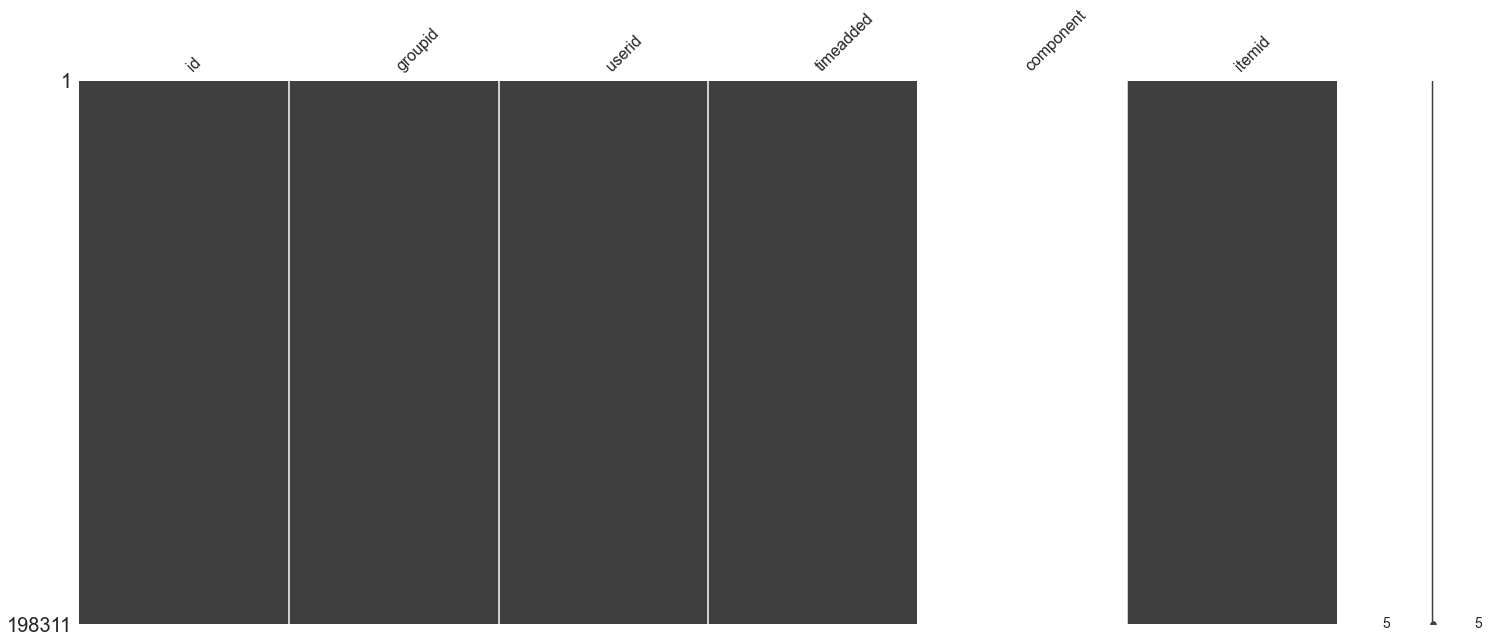

In [389]:
msno.matrix(groups)

In [390]:
groups.describe()

id        groupid         userid     timeadded  component  \
count  198311.000000  198311.000000  198311.000000  1.983110e+05        0.0   
mean   366079.852025   37160.392379   12221.869826  1.545901e+09        NaN   
std    195198.244095   24620.008634    6442.152762  6.734278e+06        NaN   
min        17.000000      14.000000       7.000000  1.535325e+09        NaN   
25%    252162.000000    7398.000000    7009.000000  1.537704e+09        NaN   
50%    363771.000000   44145.000000   11992.000000  1.550043e+09        NaN   
75%    495755.500000   49873.000000   17132.000000  1.550553e+09        NaN   
max    759093.000000   96910.000000   28230.000000  1.568951e+09        NaN   

         itemid  
count  198311.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0

Is there a way to get the peer assessment form on a given userid? We could do  sentiment analysis to figure out the performance of the userid.

# Questions

In [391]:
questions = pd.read_csv(f'{path}question.csv')
questions

id  category  parent             name  \
0         1         2       0  cloze all types   
1         2         2       1  cloze all types   
2         3         2       1  cloze all types   
3         4         2       1  cloze all types   
4         5         2       1  cloze all types   
...     ...       ...     ...              ...   
28003  5917       657       0           Skills   
28004  5918       657       0           Skills   
28005  5919       657       0           Skills   
28006  5920       657       0           Skills   
28007  5921       657       0           Skills   

                                            questiontext  questiontextformat  \
0      <p></p><span style="font-size: 1rem;">Sungai {...                   1   
1        {1:MCS:=Pahang~%0%Kedah~%0%Rajang~%0%Tembeling}                   1   
2                                          {1:SA:=Jelai}                   1   
3                                       {1:SA:=Semantan}                   1   
4      {1:MCHS:=Kuala Lipis~%0%Kuala Lumpur~%0%Bera~%...                   1   
...                                                  ...                 ...   
28003  <p><span>James has decided to implement change...                   1   
28004  <p><span>Bobby believes that what takes place ...                   1   
28005  <p><span>Bill is an effective management membe...                   1   
28006  <p><span>John does a good job for his employer...                   1   
28007  <p><span>Amit has accepted a position in Pakis...                   1   

      generalfeedback  generalfeedbackformat  defaultmark   penalty  \
0                 NaN                      1          4.0  0.333333   
1                 NaN                      1          1.0  0.000000   
2                 NaN                      1          1.0  0.000000   
3                 NaN                      1          1.0  0.000000   
4                 NaN                      1          1.0  0.000000   
...               ...                    ...          ...       ...   
28003             NaN                      1          1.0  0.333333   
28004             NaN                      1          1.0  0.333333   
28005             NaN                      1          1.0  0.333333   
28006             NaN                      1          1.0  0.333333   
28007             NaN                      1          1.0  0.333333   

             qtype  length                                   stamp  \
0      multianswer       1      spectrumv3.sel+180105093620+DlhodP   
1      multichoice       1      spectrumv3.sel+180105093620+m27RYd   
2      shortanswer       1      spectrumv3.sel+180108013850+M1fn9H   
3      shortanswer       1      spectrumv3.sel+180108013850+2slA3J   
4      multichoice       1      spectrumv3.sel+180108013850+X9DbGf   
...            ...     ...                                     ...   
28003  multichoice       1  spectrum.um.edu.my+170310013253+2HLlOq   
28004  multichoice       1  spectrum.um.edu.my+170310012754+XgISUR   
28005  multichoice       1  spectrum.um.edu.my+170310013411+1jBxHp   
28006  multichoice       1  spectrum.um.edu.my+170310013804+9HcTEh   
28007  multichoice       1  spectrum.um.edu.my+170310014046+K4cmSj   

                                      version  hidden  timecreated  \
0          spectrumv3.sel+180108014106+mpHiZk       0   1515144980   
1          spectrumv3.sel+180108014106+9hSOj8       0   1515144980   
2          spectrumv3.sel+180108014106+wnJjF8       0   1515375530   
3          spectrumv3.sel+180108014106+AfPTE4       0   1515375530   
4          spectrumv3.sel+180108014106+nTSDtx       0   1515375530   
...                                       ...     ...          ...   
28003  spectrum.um.edu.my+170310013253+1Vbgzw       0   1489109573   
28004  spectrum.um.edu.my+170310012818+hSN0o4       0   1489109274   
28005  spectrum.um.edu.my+170310013411+TqSj4V       0   1489109651   
28006  spectrum.um.edu.my+170310013804+TYi12d       0

# Questionnaire

In [392]:
questionnare=pd.read_csv(f'{path}questionnaire.csv')
questionnare

id  course                                               name  \
0      1    1295                                    Entrance Survey   
1     84     639                                CO EVALUATION (TRY)   
2    162     854                     Entrance Survey BID2004 (2017)   
3     85     639        CO EVALUATION (EARLY SEMESTER) Sem3 2015_16   
4     24     863                                Exit Survey BQC7001   
..   ...     ...                                                ...   
740  833    5121  D. Approaches and Study Skills Inventory for S...   
741  834    5124  Learning Space Preferences of Undergraduate Me...   
742  835    5124                          End of Stage 2 Evaluation   
743  836    5130                      Stage 3.2, Class of 2013/2017   
744  842    3811                               Questionnaire on GMC   

                                                 intro  introformat  qtype  \
0    <p><span>Please rate the survey based on your ...            1      1   
1                                    <p>ANSWER ALL</p>            1      1   
2                                                  NaN            1      0   
3    <p>Please rate your knowledge or understanding...            1      0   
4                           <p>Exit Survey BQC7001</p>            1      1   
..                                                 ...          ...    ...   
740  <p>Dear students,</p>\n<p>This questionnaire i...            1      1   
741                                                NaN            1      1   
742                                                NaN            1      1   
743                                                NaN            1      1   
744                                                NaN            1      0   

    respondenttype resp_eligible  resp_view  notifications    opendate  \
0         fullname           all          1              0  1472918400   
1         fullname           all          1              0           0   
2         fullname           all          1              0  1537161991   
3         fullname           all          1              0           0   
4         fullname           all          1              0  1558108800   
..             ...           ...        ...            ...         ...   
740       fullname           all          2              0  1544058000   
741       fullname           all          1              0           0   
742       fullname           all          1              0           0   
743       fullname           all          2              0           0   
744       fullname           all          1              0           0   

      closedate  resume  navigate  grade  sid  timemodified  completionsubmit  \
0             0       0         0      0    1    1468307097                 1   
1             0       1         0      0   84    1540034163                 0   
2    1537305691       0         0      0  162    1537162148                 0   
3             0       0         0      0   85    1540145156                 1   
4             0       0         0      0   24    1550648290                 0   
..          ...     ...       ...    ...  ...           ...               ...   
740  1544284800       0         0      0  830    1544054589                 0   
741           0       0         0      0  831    1547425843                 1   
742           0       0         0      0  832    1554952153                 1   
743  1504454700       0         0      0  833    1503562653                 0   
744           0       0         0      0  839    1555947804                 0   

     autonum  
0          3  
1          3  
2          3  
3          3  
4          3  
..       ...  
740        3  
741        3  
742        3  
743        3  
744        3  

[745 rows x 19 columns]

In [393]:
questionnare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                745 non-null    int64 
 1   course            745 non-null    int64 
 2   name              745 non-null    object
 3   intro             621 non-null    object
 4   introformat       745 non-null    int64 
 5   qtype             745 non-null    int64 
 6   respondenttype    745 non-null    object
 7   resp_eligible     745 non-null    object
 8   resp_view         745 non-null    int64 
 9   notifications     745 non-null    int64 
 10  opendate          745 non-null    int64 
 11  closedate         745 non-null    int64 
 12  resume            745 non-null    int64 
 13  navigate          745 non-null    int64 
 14  grade             745 non-null    int64 
 15  sid               745 non-null    int64 
 16  timemodified      745 non-null    int64 
 17  completionsubmit

In [394]:
#question types
print("question types: ")
print(questionnare.qtype.value_counts())

print('')

#number of unique courses
print("courses:")
print('There are ', questionnare.course.nunique(),' courses')

question types: 
1    490
0    253
3      1
4      1
Name: qtype, dtype: int64

courses:
There are  306  courses


# Questionnaire attempts

In [395]:
questionnaireattempts = pd.read_csv(f'{path}questionnaire_attempts.csv')
questionnaireattempts

id  qid  userid   rid  timemodified
0        2    7    2575     2    1536826661
1        3   10    2575     3    1536826708
2        4    7    2544     4    1536831458
3        5    7    2567     5    1536831577
4        6   10    2544     6    1536831584
...    ...  ...     ...   ...           ...
5337  5745  531   25539  5802    1561696780
5338  5746  909   28166  5803    1561773611
5339  5747  461    8607  5804    1561813038
5340  5748  909   28139  5805    1561867092
5341  5749  909   28198  5806    1561872061

[5342 rows x 5 columns]

In [396]:
questionnaireattempts[questionnaireattempts.qid==7]

id  qid  userid  rid  timemodified
0      2    7    2575    2    1536826661
2      4    7    2544    4    1536831458
3      5    7    2567    5    1536831577
6      8    7   15516    8    1536832555
9     12    7    2549   12    1536835164
..   ...  ...     ...  ...           ...
177  183    7    2533  183    1537159918
210  217    7    2557  218    1537239126
227  236    7   15518  239    1537391901
229  238    7    2536  241    1537398378
232  241    7    2538  244    1537403849

[61 rows x 5 columns]

In [397]:
questionnaireattempts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5342 entries, 0 to 5341
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   id            5342 non-null   int64
 1   qid           5342 non-null   int64
 2   userid        5342 non-null   int64
 3   rid           5342 non-null   int64
 4   timemodified  5342 non-null   int64
dtypes: int64(5)
memory usage: 208.8 KB


In [398]:
#number of unique userid's
print(questionnaireattempts.userid.nunique())

#number of unique questionnaires
print(questionnaireattempts.qid.nunique())

#number of unique rid's
print(questionnaireattempts.rid.nunique())

2968
352
5342


Therefore one qid can have multiple rid's.

# Questionnaire questions

In [399]:
questionnaire_questions = pd.read_csv(f'{path}questionnaire_question.csv')
questionnaire_questions

id  survey_id                           name  type_id  result_id  \
0        3          1                              3        4        NaN   
1       17          7                     Attendance        8        NaN   
2      737        302                            CO3        4        NaN   
3        6          2                              3        4        NaN   
4      739        302                            CO2        4        NaN   
...    ...        ...                            ...      ...        ...   
5022  5449        862                            NaN       99        NaN   
5023  5452        862                            Q22        3        NaN   
5024  5455        906                       Language        1        NaN   
5025  5457        906                    Interaction        1        NaN   
5026  5417        862  GRP-Academic Struggle/Failure        1        NaN   

      length  precise  position  \
0          0        0        -3   
1          5        0        -3   
2          1        0        -2   
3          0        0        -3   
4          1        0        -3   
...      ...      ...       ...   
5022       0        0        33   
5023      40        0        36   
5024       0        0         2   
5025       0        0         4   
5026       0        0         1   

                                                content required deleted  \
0     <p>Produce an abstract, literature review and ...        y       n   
1     <p><span style="font-size: large;"> </span></p...        n       n   
2     <p>I can discuss on the existing national stra...        y       n   
3     <p>Produce an abstract, literature review and ...        y       n   
4     <p>I can determine main strategies required in...        y       n   
...                                                 ...      ...     ...   
5022                                              break        n       n   
5023  <p><span style="font-size: small;">What kind o...        y       n   
5024  <p>I prefer the present usage of mostly Englis...        y       n   
5025  <p>I feel connected to the lecturer during cla...        y       n   
5026  <p align="center"><strong>Consent for Particip...        y       n   

      dependquestion  dependchoice  
0                  0             0  
1                  0             0  
2                  0             0  
3                  0             0  
4                  0             0  
...              ...           ...  
5022               0             0  
5023            5417             0  
5024               0             0  
5025               0             0  
5026               0             0  

[5027 rows x 13 columns]

In [400]:
questionnaire_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5027 entries, 0 to 5026
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5027 non-null   int64  
 1   survey_id       5027 non-null   int64  
 2   name            3343 non-null   object 
 3   type_id         5027 non-null   int64  
 4   result_id       0 non-null      float64
 5   length          5027 non-null   int64  
 6   precise         5027 non-null   int64  
 7   position        5027 non-null   int64  
 8   content         5027 non-null   object 
 9   required        5027 non-null   object 
 10  deleted         5027 non-null   object 
 11  dependquestion  5027 non-null   int64  
 12  dependchoice    5027 non-null   int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 510.7+ KB


Therefore, all the id's are unique. **We can set it as index.**

In [401]:
#setting the id as index
questionnaire_questions.set_index('id')

survey_id                           name  type_id  result_id  length  \
id                                                                           
3             1                              3        4        NaN       0   
17            7                     Attendance        8        NaN       5   
737         302                            CO3        4        NaN       1   
6             2                              3        4        NaN       0   
739         302                            CO2        4        NaN       1   
...         ...                            ...      ...        ...     ...   
5449        862                            NaN       99        NaN       0   
5452        862                            Q22        3        NaN      40   
5455        906                       Language        1        NaN       0   
5457        906                    Interaction        1        NaN       0   
5417        862  GRP-Academic Struggle/Failure        1        NaN       0   

      precise  position                                            content  \
id                                                                           
3           0        -3  <p>Produce an abstract, literature review and ...   
17          0        -3  <p><span style="font-size: large;"> </span></p...   
737         0        -2  <p>I can discuss on the existing national stra...   
6           0        -3  <p>Produce an abstract, literature review and ...   
739         0        -3  <p>I can determine main strategies required in...   
...       ...       ...                                                ...   
5449        0        33                                              break   
5452        0        36  <p><span style="font-size: small;">What kind o...   
5455        0         2  <p>I prefer the present usage of mostly Englis...   
5457        0         4  <p>I feel connected to the lecturer during cla...   
5417        0         1  <p align="center"><strong>Consent for Particip...   

     required deleted  dependquestion  dependchoice  
id                                                   
3           y       n               0             0  
17          n       n               0             0  
737         y       n               0             0  
6           y       n               0             0  
739         y       n               0             0  
...       ...     ...             ...           ...  
5449        n       n               0             0  
5452        y       n            5417             0  
5455        y       n               0             0  
5457        y       n               0             0  
5417        y       n               0             0  

[5027 rows x 12 columns]

In [402]:
#number of unique surveys
print(questionnaire_questions.survey_id.nunique())

678


# Questionnaire response

In [403]:
questionnaire_response=pd.read_csv(f'{path}questionnaire_response.csv')
questionnaire_response

id  survey_id   submitted complete  grade  userid
0        2          7  1536826661        y      0    2575
1        3         10  1536826708        y      0    2575
2        4          7  1536831458        y      0    2544
3        5          7  1536831577        y      0    2567
4        6         10  1536831584        y      0    2544
...    ...        ...         ...      ...    ...     ...
5393  5802        529  1561696780        y      0   25539
5394  5803        906  1561773611        y      0   28166
5395  5804        461  1561813038        y      0    8607
5396  5805        906  1561867092        y      0   28139
5397  5806        906  1561872061        y      0   28198

[5398 rows x 6 columns]

In [404]:
print(questionnaire_response.userid.nunique())
print('')

#checking how many completed and how many didn not
print(questionnaire_response.complete.value_counts())

print('')

#checking the type of grades given
print(questionnaire_response.grade.value_counts())

3010

y    5342
n      56
Name: complete, dtype: int64

0      5334
1        31
5        19
100      14
Name: grade, dtype: int64


Therefore, there is data on only 3010 users.

# Consolidation of info on questionnaires

The only dataframes that have meaningful user-centric information are the questionnaire_attempts and questionnaire_response tables. The number of attempts for each question shall be extracted and put into the questionnaire responses dataframe

In [405]:
questionnaireattempts.head()

id  qid  userid  rid  timemodified
0   2    7    2575    2    1536826661
1   3   10    2575    3    1536826708
2   4    7    2544    4    1536831458
3   5    7    2567    5    1536831577
4   6   10    2544    6    1536831584

In [406]:
questionnaireattempts.shape[0]

5342

In [407]:
user_3567 = questionnaireattempts[questionnaireattempts.userid==2567]
for q in user_3567.qid:
    print(q)

7
10


In [408]:
users = []
qids = []
attempts_count = []
for user in questionnaireattempts.sort_values(by='userid').userid.unique():
    user_attempts = questionnaireattempts[questionnaireattempts.userid==user]
    for q in user_attempts.qid.unique():
        users.append(user)
        qids.append(q)
        attempts_count.append(user_attempts[user_attempts.qid==q].rid.nunique())

In [409]:
users[1]

358

In [410]:
print(len(attempts_count))
print(len(qids))
print(len(users))

5247
5247
5247


In [411]:
attempts = pd.DataFrame({'userid':users,'qid':qids,'attempts_count':attempts_count})

In [412]:
attempts.head()

userid  qid  attempts_count
0     122  663               1
1     358  575               1
2     358  567               1
3     358  579               1
4     358  590               1

In [413]:
attempts

userid  qid  attempts_count
0        122  663               1
1        358  575               1
2        358  567               1
3        358  579               1
4        358  590               1
...      ...  ...             ...
5242   26487  361               1
5243   26487  365               1
5244   28139  909               1
5245   28166  909               1
5246   28198  909               1

[5247 rows x 3 columns]

In [414]:
attempts.to_csv(f'{ppath}questionnaire.csv')

# Surveys

In [415]:
surveys = pd.read_csv(f'{path}survey.csv')

In [416]:
surveys

id  userid  survey  question        time answer1  answer2
0          1   16425       6        45  1536761233       4      NaN
1          2   16425       6        46  1536761233       1      NaN
2          3   16425       6        47  1536761233       4      NaN
3          4   16425       6        48  1536761233       4      NaN
4          5   16425       6        49  1536761233       4      NaN
...      ...     ...     ...       ...         ...     ...      ...
10333  10512   28114     159        60  1561901015       4      NaN
10334  10513   28114     159        61  1561901015       4      NaN
10335  10514   28114     159        62  1561901015       4      NaN
10336  10515   28114     159        63  1561901015       4      NaN
10337  10516   28114     159        64  1561901015       2      NaN

[10338 rows x 7 columns]

In [417]:
survey_per_user = items_per_user(surveys, 'survey')

In [418]:
survey_per_user

userid  number_of_surveys
0        95                  1
1       423                  1
2       641                  1
3       710                  1
4      1117                  1
..      ...                ...
441   28114                  1
442   28116                  1
443   28139                  1
444   28166                  1
445   28198                  1

[446 rows x 2 columns]

In [419]:
surveys.userid.nunique()

446

In [420]:
surveys.question.nunique()

51

In [421]:
surveys.survey.nunique()

40

In [422]:
surveyquestion_per_user = items_per_user(surveys,'question')

In [423]:
surveyquestion_per_user

userid  number_of_questions
0        95                   20
1       423                    5
2       641                    5
3       710                    5
4      1117                    5
..      ...                  ...
441   28114                   20
442   28116                   20
443   28139                   20
444   28166                   20
445   28198                   20

[446 rows x 2 columns]

In [424]:
# survey_per_user.to_csv(f'{ppath}survey_per_user.csv')
# surveyquestion_per_user.to_csv(f'{ppath}surveyquestion_per_user.csv')

# Quiz attempts

In [202]:
quiz_attempts=pd.read_csv(f'{path}quiz_attempts.csv')
quiz_attempts

id  quiz  userid  attempt  uniqueid  \
0       5933   424    6118        1      6619   
1         68    16   14287        2        88   
2          2    16      97        1        11   
3        185    17    5417        2       208   
4       4737   376   11315        2      5258   
...      ...   ...     ...      ...       ...   
72061  76476  1189     968        1     82617   
72062  76477  1430    1048        1     82618   
72063  76478  2212   18767        1     82620   
72064  36171  1914     981        1     39270   
72065  25401  1444     981        1     27826   

                                                  layout  currentpage  \
0                                    1,0,2,0,3,0,4,0,5,0            4   
1                                 1,2,3,4,5,6,7,8,9,10,0            0   
2                                 1,2,3,4,5,6,7,8,9,10,0            0   
3                                                    1,0            0   
4                                                    1,0            0   
...                                                  ...          ...   
72061  1,2,3,4,5,0,6,7,8,9,10,0,11,12,13,14,15,0,16,1...            0   
72062  1,22,10,5,19,21,17,20,2,13,9,4,11,6,3,14,15,16...            0   
72063  1,0,2,0,3,0,4,0,5,0,6,0,7,0,8,0,9,0,10,0,11,0,...            0   
72064           1,0,2,0,3,0,4,0,5,0,6,0,7,0,8,0,9,0,10,0            9   
72065                                            1,2,3,0            0   

       preview       state   timestart  timefinish  timemodified  \
0            0    finished  1541322307  1541331808    1547701814   
1            0    finished  1536757686  1536757792    1536757792   
2            1  inprogress  1536128247           0    1536128247   
3            0    finished  1536826143  1536826166    1536826166   
4            0    finished  1540737475  1542862254    1542862254   
...        ...         ...         ...         ...           ...   
72061        1  inprogress  1594866723           0    1594866723   
72062        1  inprogress  1602139692           0    1602139692   
72063        1  inprogress  1606793013           0    1606793013   
72064        1  inprogress  1553832698           0    1553832713   
72065        1  inprogress  1552534012           0    1552534069   

       timemodifiedoffline  timecheckstate  sumgrades  
0                        0             NaN        NaN  
1                        0             NaN       10.0  
2                        0             NaN        NaN  
3                        0             NaN        1.0  
4                        0             NaN        0.0  
...                    ...             ...        ...  
72061                    0             NaN        NaN  
72062                    0             NaN        NaN  
72063                    0             NaN        NaN  
72064                    0             NaN        NaN  
72065                    0             NaN        NaN  

[72066 rows x 15 columns]

In [ ]:
quiz_attempts.info()

In [203]:
# number of unique users
print(quiz_attempts.userid.nunique())

# number of uniqueid's
print(quiz_attempts.uniqueid.nunique())

11999
72066


checking if there a user has attempted a quiz twice and if that information is redundantly stored

In [441]:
quiz_attempts_1 = quiz_attempts.loc[quiz_attempts.attempt==1]
quiz_attempts_2= quiz_attempts.loc[quiz_attempts.attempt==2]

In [442]:
quiz_attempts_1.reset_index(inplace=True,drop=True)

In [443]:
quiz_attempts_2.reset_index(inplace=True,drop=True)

In [444]:
quiz_attempts_1

id  quiz  userid  attempt  uniqueid  \
0       5933   424    6118        1      6619   
1          2    16      97        1        11   
2         26    16    5431        1        39   
3         15    52   10418        1        26   
4        284    16    5411        1       309   
...      ...   ...     ...      ...       ...   
54834  76476  1189     968        1     82617   
54835  76477  1430    1048        1     82618   
54836  76478  2212   18767        1     82620   
54837  36171  1914     981        1     39270   
54838  25401  1444     981        1     27826   

                                                  layout  currentpage  \
0                                    1,0,2,0,3,0,4,0,5,0            4   
1                                 1,2,3,4,5,6,7,8,9,10,0            0   
2                                 1,2,3,4,5,6,7,8,9,10,0            0   
3                                1,0,2,0,3,0,4,0,5,0,6,0            5   
4                                 1,2,3,4,5,6,7,8,9,10,0            0   
...                                                  ...          ...   
54834  1,2,3,4,5,0,6,7,8,9,10,0,11,12,13,14,15,0,16,1...            0   
54835  1,22,10,5,19,21,17,20,2,13,9,4,11,6,3,14,15,16...            0   
54836  1,0,2,0,3,0,4,0,5,0,6,0,7,0,8,0,9,0,10,0,11,0,...            0   
54837           1,0,2,0,3,0,4,0,5,0,6,0,7,0,8,0,9,0,10,0            9   
54838                                            1,2,3,0            0   

       preview       state   timestart  timefinish  timemodified  \
0            0    finished  1541322307  1541331808    1547701814   
1            1  inprogress  1536128247           0    1536128247   
2            0  inprogress  1536741298           0    1536741298   
3            0    finished  1536719254  1536720068    1536819690   
4            0  inprogress  1537002411           0    1537002411   
...        ...         ...         ...         ...           ...   
54834        1  inprogress  1594866723           0    1594866723   
54835        1  inprogress  1602139692           0    1602139692   
54836        1  inprogress  1606793013           0    1606793013   
54837        1  inprogress  1553832698           0    1553832713   
54838        1  inprogress  1552534012           0    1552534069   

       timemodifiedoffline  timecheckstate  sumgrades  
0                        0             NaN        NaN  
1                        0             NaN        NaN  
2                        0             NaN        NaN  
3                        0             NaN        NaN  
4                        0             NaN        NaN  
...                    ...             ...        ...  
54834                    0             NaN        NaN  
54835                    0             NaN        NaN  
54836                    0             NaN        NaN  
54837                    0             NaN        NaN  
54838                    0             NaN        NaN  

[54839 rows x 15 columns]

In [445]:
quiz_attempts_2

id  quiz  userid  attempt  uniqueid  \
0         68    16   14287        2        88   
1        185    17    5417        2       208   
2       4737   376   11315        2      5258   
3         45    16    5417        2        65   
4         52    16    5410        2        72   
...      ...   ...     ...      ...       ...   
12003  76438  2482   28167        2     82578   
12004  76441  2482   28161        2     82581   
12005  76430  2477   13393        2     82570   
12006  76437  2471   28167        2     82577   
12007  76453  2478   13393        2     82593   

                                                  layout  currentpage  \
0                                 1,2,3,4,5,6,7,8,9,10,0            0   
1                                                    1,0            0   
2                                                    1,0            0   
3                                 1,2,3,4,5,6,7,8,9,10,0            0   
4                                 1,2,3,4,5,6,7,8,9,10,0            0   
...                                                  ...          ...   
12003                                            1,0,2,0            1   
12004                                            1,0,2,0            1   
12005  10,13,16,0,3,32,19,0,25,33,30,0,8,9,22,0,23,29...           10   
12006                                                1,0            0   
12007  35,0,12,0,44,0,28,0,11,0,34,0,5,0,16,0,20,0,21...           43   

       preview       state   timestart  timefinish  timemodified  \
0            0    finished  1536757686  1536757792    1536757792   
1            0    finished  1536826143  1536826166    1536826166   
2            0    finished  1540737475  1542862254    1542862254   
3            0    finished  1536750628  1536750710    1536750710   
4            0    finished  1536754569  1536755485    1536755485   
...        ...         ...         ...         ...           ...   
12003        0    finished  1561894063  1561894094    1561894094   
12004        0    finished  1561896942  1561896962    1561896962   
12005        0    finished  1561888101  1561888531    1561888531   
12006        0  inprogress  1561894028           0    1561894028   
12007        0    finished  1561906334  1561908919    1561908919   

       timemodifiedoffline  timecheckstate  sumgrades  
0                        0             NaN       10.0  
1                        0             NaN        1.0  
2                        0             NaN        0.0  
3                        0             NaN       10.0  
4                        0             NaN        9.0  
...                    ...             ...        ...  
12003                    0             NaN        2.0  
12004                    0             NaN        2.0  
12005                    0             NaN       41.0  
12006                    0             NaN        NaN  
12007                    0             NaN       39.0  

[12008 rows x 15 columns]

In [450]:
quiz_attempts_1_users = quiz_attempts_1.userid.unique()
quiz_attempts_2_users = quiz_attempts_2.userid.unique()

In [ ]:
for user1 in quiz_attempts_1_users:
    for user2 in quiz_attempts_2_users:
        if user1==user2:
            print(user1)


## attempt-stats

stats on quiz attempts for each user

In [205]:
quizattempt_count = find_stats(quiz_attempts,'attempt')
quizattempt_count
quizattempt_count.to_csv(f'{ppath}quizattempt_count.csv')

In [206]:
quizattempt_count

userid  max_attempt  min_attempt  mean_attempt
0        6118            1            1      1.000000
1       14287            3            1      1.535714
2          97            1            1      1.000000
3        5417            2            1      1.227273
4       11315            2            1      1.333333
...       ...          ...          ...           ...
11994   28151            1            1      1.000000
11995     734            1            1      1.000000
11996     824            1            1      1.000000
11997     325            1            1      1.000000
11998   18767            1            1      1.000000

[11999 rows x 4 columns]

## quiz count per user

In [208]:
quiz_per_user = items_per_user(quiz_attempts,'quiz')

In [209]:
quiz_per_user

userid  number_of_quizs
0           7                2
1           9                1
2          32                1
3          39                2
4          40                2
...       ...              ...
11994   28204                1
11995   28206                1
11996   28214                1
11997   28216                2
11998   28217                1

[11999 rows x 2 columns]

In [210]:
fig = px.box(quiz_per_user,
             y='number_of_quizs')
fig.show()

# Quiz grades

In [211]:
quiz_grades = pd.read_csv(f'{path}quiz_grades.csv')
quiz_grades

id  quiz  userid     grade  timemodified
0          1    16    5357  10.00000    1536741761
1          2    16   14301   8.00000    1536741779
2          3    16    5432   7.00000    1536742149
3          4    16    5417  10.00000    1536750710
4          5    16    5410   9.00000    1536755485
...      ...   ...     ...       ...           ...
50023  52180  2478   13393  36.79245    1561908919
50024  52182  2476   16199  18.88889    1561909637
50025  52163  2477   13393  41.00000    1561909676
50026  52183  2487   24429  14.00000    1565890851
50027  52184  2486    5129  12.00000    1566040769

[50028 rows x 5 columns]

## Missing values

<AxesSubplot:>

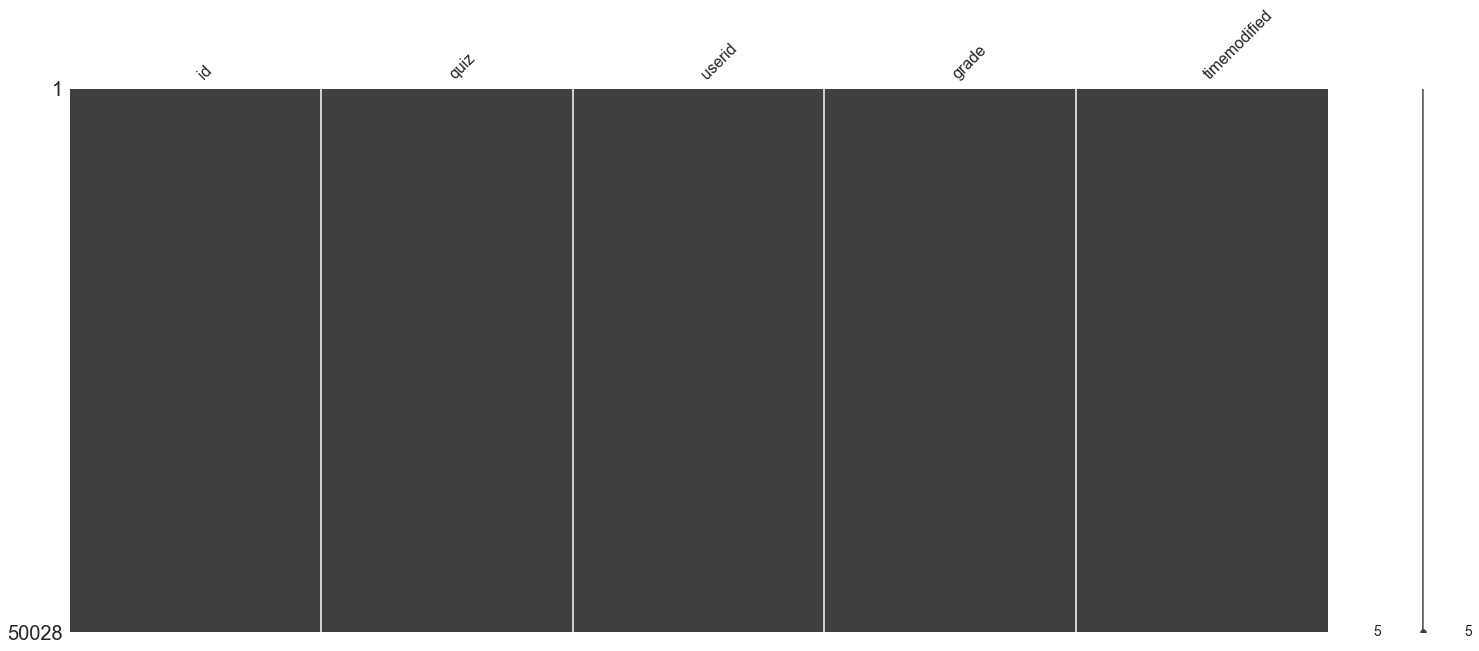

In [212]:
msno.matrix(quiz_grades)

## Grades scaled at 10

In [213]:
quiz_grades[quiz_grades["grade"]<10]

id  quiz  userid    grade  timemodified
1          2    16   14301  8.00000    1536741779
2          3    16    5432  7.00000    1536742149
4          5    16    5410  9.00000    1536755485
5          6    16   14247  5.00000    1536755637
6          7    16   14246  7.00000    1536755776
...      ...   ...     ...      ...           ...
49984  52141  2438   15952  3.33333    1561814437
49989  52146  2482   28139  5.00000    1561828961
50003  52160  2482   28122  0.00000    1561883163
50009  52168  2482   28206  5.00000    1561892802
50014  52172  2482   28216  0.00000    1561901980

[19670 rows x 5 columns]

## Grades above 10 and below 40 (assuming these will be scaled at 100)

## Grades scaled above 10 and below 40

In [214]:
qgrades_btn_10_40 = pcnt_df(quiz_grades,"grade", lbound=10,hbound=41) #grade 11 to grade 39
print(qgrades_btn_10_40)

qgrades_10 = pcnt_df(quiz_grades,"grade",hbound=11) #upto grade=9
print(qgrades_10)

qgrades_btn_40_100 = pcnt_df(quiz_grades,"grade", lbound=40,hbound=101)
print(qgrades_btn_40_100)

qgrades_above100 = pcnt_df(quiz_grades,"grade", lbound=100)
print(qgrades_above100)

19.311185735987845
77.83641160949868
3.206204525465739
0.009994403134244823


<AxesSubplot:>

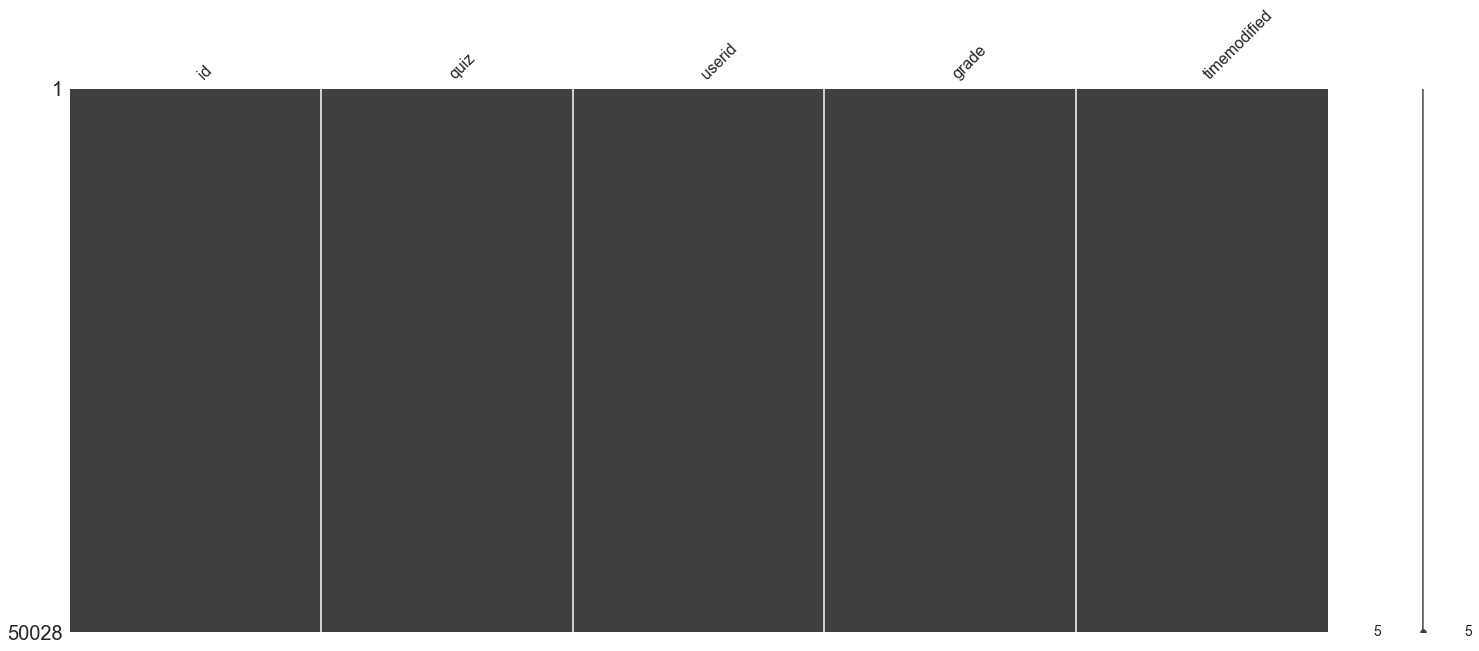

In [215]:
msno.matrix(quiz_grades)

## Joining Quiz attempts and quiz grades

In [ ]:
quiz_attempts

In [ ]:
quiz_grades

In [ ]:
print(quiz_attempts.userid.nunique())
print(quiz_grades.userid.nunique())

print("#"*30)
quiz_merged = quiz_grades.merge(quiz_attempts,on=['userid','quiz'])
quiz_merged = quiz_merged[['quiz','userid','attempt','grade','uniqueid','sumgrades']]
print(quiz_merged.userid.nunique())


In [ ]:
quiz_merged

In [ ]:
# quiz_merged.to_csv(f'{ppath}quiz_grades.csv')

## no of quizes per user

In [ ]:
quiz_per_user = items_per_user(quiz_merged,'quiz')
quizattempt_per_user = items_per_user(quiz_merged,'attempt')

# quiz_per_user.to_csv(f'{ppath}quiz_per_user.csv')
# quizattempt_per_user.to_csv(f'{ppath}quizattempt_per_user.csv')

# Users

In [ ]:
users = pd.read_csv(f'{path}users.csv')

In [ ]:
users

In [ ]:
users.id.nunique()

In [ ]:
users.sort_values(by='id',inplace=True )

In [ ]:
users

In [ ]:
users.set_index('id')

There are a lot of values in the lastname column that are not really data (The ones with '.')

In [ ]:
#Checking for invalid values
users.info()

In [ ]:
print('There are ',
      users[users.firstname=='.'].shape[0],
      ' users with a dummmy firstname')

print('There are ',
      users[users.lastname=='.'].shape[0],
      ' users with a dummy lastname')

print('There are ',
      users[users.email=='.'].shape[0],
      ' users with a dummy email')



## Script to classify students from other personnel

In [ ]:
import re

In [ ]:
#function to find student emails
def find_student_email(email):
    """find_student_email takes an email. If the email is of a um student, the email will be returned. If not, the email will be skipped over"""

    pattern = re.compile(r'[a-zA-Z0-9]+@siswa.um.edu.my$') 
    if type(email)==str:
        if(re.search(pattern,email)):
            return email
        else:
            pass
    else:
        pass

In [ ]:
# Testing the function
e = 'bryanraj@siswa.um.edu.my'
if find_student_email(e)==e:
    print(1)

In [ ]:
student_emails = filter(find_student_email, users.email) # filtering the emails and creating an iterator
student_emails = list(student_emails) # converting the iterator to a list
student_emails[0:5] 

In [ ]:
print(len(student_emails))
print(users.shape)

## Creating a dataframe for only students with the script

In [ ]:
students = users[users.email.isin(student_emails)]
students

In [ ]:
#students.to_csv('../data/processed/students.csv')

The student data has been stored as a csv in '/data/processed/'.

## Groups (Only students)

In [ ]:
groups

In [ ]:
groups = groups[groups.userid.isin(students.id)]

In [ ]:
groups

# Forum posts (only students)

In [ ]:
forumposts

In [ ]:
forumposts_students = forumposts[forumposts.userid.isin(students.id)]

In [ ]:
forumposts_students

In [ ]:
forumposts_students.describe()

In [ ]:
#forumposts_students.to_csv(f'{ppath}forumposts_students.csv')

## Merging forumposts with groups

In [ ]:
groups

In [ ]:
forumposts_students

In [ ]:
print(forumposts_students.userid.nunique())
print(groups.userid.nunique())

Verifying whether one user is in one group only

In [ ]:
print(groups[groups.userid==3610])

Therefore, one user can be in >1 groups

Therefore, the groups df should have more groups.

In [ ]:
forumposts_students_with_groups = groups.merge(forumposts_students, on=['userid'], how='right')

In [ ]:
forumposts_students_with_groups.drop(columns=['id_x','timeadded','component','itemid','messageformat','messagetrust','totalscore','mailnow'],inplace=True)

In [ ]:
forumposts_students_with_groups

The number of userid's should be that of the forumposts_students, not the group df's. Because not all students from groups participated in forums.

In [ ]:
forumposts_students_with_groups.userid.nunique()

In [ ]:
forumposts_students_with_groups.rename(columns={'groupid':'user_groupid','id_y':'postid'},inplace=True)

In [ ]:
forumposts_students_with_groups

In [ ]:
msno.matrix(forumposts_students_with_groups)

In [ ]:
forumposts_students_with_groups.describe()

In [ ]:
print(forumposts_students_with_groups.dtypes)
print(forumposts_students_with_groups[forumposts_students_with_groups.user_groupid==-1])

In [ ]:
#forumposts_students_with_groups.to_csv(f'{ppath}forumposts_students_with_groups.csv')

# Forum Metadata

In [ ]:
forum_meta = pd.read_csv(f'{path}forum.csv')

In [ ]:
forum_meta

Need to know what the 'forcesubscribe' column means
(Update: No need)

In [ ]:
forum_meta = forum_meta[['id','course','type','name','forcesubscribe']]

In [ ]:
forum_meta

# Forum Discussions

In [ ]:
discussions = pd.read_csv(f'{path}discussions.csv')

In [ ]:
discussions

In [ ]:
discussions.describe()

In [ ]:
msno.matrix(discussions)

In [ ]:
discussions.columns

In [ ]:
discussions= discussions[discussions.userid.isin(students.id)]

In [ ]:
discussions

In [ ]:
print(discussions.course.nunique())

print(discussions.userid.nunique())

print(discussions.groupid.nunique())

print(discussions.forum.nunique())

# Forum subscriptions

In [ ]:
forum_subscriptions = pd.read_csv(f'{path}forum_subscriptions.csv')

In [ ]:
forum_subscriptions

This table does not have enough data

# Consolidation of forum activity

In [ ]:
forum_meta

In [ ]:
forumposts_students

In [ ]:
discussions

In [ ]:
msno.matrix(forumposts_students)

In [ ]:
msno.matrix(discussions)

In [ ]:
# checking number of discussions in posts df and discussion (should be the same)
print(forumposts_students.discussion.nunique())
print(discussions.id.nunique())

# checking number of forums in both df's
print(forumposts.id.nunique())
print(discussions.forum.nunique())

## How to measure engagement/activeness on forums

The measurement of how active a student is on forums can be seen as a relative measure, relative to how other students are. This relative measurement is better than absolute measurements taken from , for example the number of posts by a student. This is because if the forum was just an announcement, then the forum does not encourage students to interact with the post. Therefore, most students won't need to interact. There will be a few exceptions when a student might ask 1 question regarding the announcement, but this isn't an indication that this student is more active. Therefore, relative measurements will be effective when a forum has at least 1 post from 50% of the students, for example.

We can go 3 ways:
1. Consider a threshold number of posts: Do a barplot of x=number of posts, y=discussion. Then, identify the set of discussions that have a number of posts that is greater than a certain number. Or,
2. Consider a threshold number of students: If more than 50% of the students are involved, it will be identified as a discussion that encourages egagement. Do a barplot/scatterplot of x=discussion vs y=number of users
Q. How to find this "50% of the students"? We could have used the group id. But the group table is not correct, or is not useful. Therefore, there's no way to find the number of students that WERE SUPPOSED to post in the discussion or in other words, the number of students that are 'subscribed' to the discussion'.
3. We could also see the number of users participating in a post and then add an engagement point for each 'extra' post that a student has made. For example if a disussion has 20 users and most users have posted 1 post, we give the users that have posted >1 posts, an engagement point.

### no of posts by a user in a discussion

In [ ]:
forumposts_students

In [ ]:
forumposts_students[forumposts_students.userid==6269]

In [ ]:
forumposts_students[(forumposts_students.userid==6271)&(forumposts_students.discussion==13)].id

Script for finding number of posts by a student in each discussion

In [ ]:
discussion_for_all_users = []
users = []
posts = []
for user in tqdm_notebook(forumposts_students.userid.unique()): # this loop will select the portion of a dataframe attributable to a single user.
    posts_by_user = forumposts_students[forumposts_students.userid==user]
    #discussion_for_this_user = []
    #posts_user_all_d = []

    for d in posts_by_user.discussion.unique(): # this loop will iterate through all the discussions that a user participated in

        posts_in_d = posts_by_user[posts_by_user.discussion==d].id.nunique() # counting number of posts in this discussion
        posts.append(posts_in_d) # adding the post count to the main posts list
        discussion_for_all_users.append(d) # adding the discussion to list of discussions for all users
        users.append(user) # this will add the same user for as many discussions as they participated in




    sleep(0.001)



In [ ]:
posts_per_discussion = pd.DataFrame({'userid':users,
                                     'discussion':discussion_for_all_users,
                                     'no_of_posts':posts})

In [ ]:
posts_per_discussion

In [ ]:
posts_per_discussion.describe()

In [ ]:
fig = px.scatter(posts_per_discussion,
                 x="userid",
                 y="no_of_posts",
                 color="no_of_posts",
                 template=template)
fig.show()

In [ ]:
posts_per_discussion[posts_per_discussion.no_of_posts>20]

In [ ]:
# posts_per_discussion.to_csv(f'{ppath}posts_per_discussion_per_user.csv')

### no of users per discussion

An example:

In [ ]:
posts_per_discussion[posts_per_discussion.discussion==21706].userid.nunique()

The function to count number of userid's

In [ ]:
def find_users_per_discussion(df,feature, parent_feature=None):
    """ """

    #preprocessing: sort the df by userid
    discussions = df.sort_values(by='discussion').discussion.unique()
    n_items_per_user = []
    if feature not in df.columns:
        print('The column', feature,' does not exist')
        pass
    if parent_feature==None:

        for d in discussions:
            #select portion of dataframe specific to the single user and then count number of unique values for the feature
            n_items=df[df.discussion==d][feature].nunique()
            #add the data to the array
            n_items_per_user.append(n_items)
            #create the dataframe
        feature = 'number_of_' + feature +'s' #changing the name of the item column
        items_per_user_df = pd.DataFrame({'discussion':discussions,feature:n_items_per_user})

    return items_per_user_df

Usage

In [ ]:
users_per_discussion = find_users_per_discussion(posts_per_discussion,'userid')

Verification

In [ ]:
users_per_discussion

In [ ]:
users_per_discussion.loc[users_per_discussion.discussion==21706]

Visualization

In [ ]:
fig = px.scatter(users_per_discussion,
                 x="discussion",
                 y="number_of_userids",
                 color="number_of_userids",
                 # trendline='lowess',
                 trendline='rolling', # moving average model fitted
                 trendline_options=dict(window=20), # window size of moving average model
                 template=template)
fig.show()

In [ ]:
users_per_discussion.describe()

In [ ]:
# users_per_discussion.to_csv(f'{ppath}users_per_discussion.csv')

## Finding the threshold value of posts that points to how engaged a student is

Preferrably different for each discussion?

### Distribution of posts

The following the distribution of posts, not taking into account the discussion where the post exists.

We'll make a histogram. Hence, calculating nbins first.

In [ ]:
from math import sqrt,ceil,log
from numpy import max,min

In [ ]:
# sturges rule
nbins_sturges = ceil(log(posts_per_discussion.size,2))+1 # no of bins = ceil(log2(n))+1
print(posts_per_discussion.size)
print(nbins_sturges)

# Freedman-Diaconis rule
q3, q1 = np.percentile(posts_per_discussion, [75 ,25])
iqr = q3 - q1
print(iqr)
h = 2*iqr/posts_per_discussion.size**(1./3.)
print(h)
k = (max(posts_per_discussion.no_of_posts)-min(posts_per_discussion.no_of_posts))/h
print(k)

In [194]:
px.histogram(posts_per_discussion[posts_per_discussion.no_of_posts>2],
             x='no_of_posts',
             y='discussion',
             #nbins=nbins_sturges,
             #nbins=100
             )

NameError: name 'posts_per_discussion' is not defined

# Enrolments

In [ ]:
enrolment = pd.read_csv(f'{path}user_enrolments.csv')

In [ ]:
enrolment

In [ ]:
enrolment.info()

In [ ]:
msno.matrix(enrolment)

In [ ]:
enrolment.tail()

In [ ]:

#number of users
print(enrolment.userid.nunique())

#number of enrol id's
print(enrolment.enrolid.nunique())

#number of statuses
print(enrolment.status.value_counts())



# Standard log

In [ ]:
standard_log = pd.read_csv(f'{path}logstore_standard_log.csv')

In [ ]:
standard_log = standard_log[['id','component','action','target','userid','courseid','timecreated','origin']]

In [ ]:
standard_log.head()

In [ ]:
standard_log.info()

In [ ]:
print(standard_log.userid.nunique())

print('')
print('types of actions')
print(standard_log.action.value_counts())

## Filtering the log of students only

Methodology: 

The userids of the students have been identified from the users dataframe and have been stored in the students dataframe. Therefore, only the portion of the standard_log dataframe that exists in the students dataframe shall be kept.

In [ ]:
student_log = standard_log[standard_log.userid.isin(students.id)]

In [ ]:
student_log[0:10]

In [ ]:
print(student_log.userid.nunique())

print('')
print('types of actions')
print('-'*30)
print(student_log.action.nunique(),' types of actions')
print("")
print(student_log.action.value_counts())

In [ ]:
# student_log.to_csv(f'{ppath}student_log.csv')

In [ ]:
student_logins = student_log[student_log.action=='loggedin']
student_logins.head()

In [ ]:
student_logins.describe()

The courseid column seems to be meaningless. So that will be dropped

In [ ]:
student_logins.drop(columns='courseid',inplace=True)

In [ ]:
# student_logins.to_csv(f'{ppath}logins.csv')
student_logins.head()

In [ ]:
login_count = items_per_user(student_logins,'timecreated')

In [ ]:
login_count.rename(columns={'number_of_timecreateds': 'number_of_logins'},inplace=True)

In [ ]:
# login_count.to_csv(f'{ppath}login_count.csv')

In [ ]:
fig = px.scatter(login_count,
                 x='userid',
                 y='number_of_logins',
                 color='number_of_logins')
fig.show()

In [ ]:
fig =  px.box(login_count,
              y='number_of_logins')
fig.show()